# YanuX Skeletron User Study

## Imports

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, date, time
import plot_likert

## Helper Functions

In [2]:
def print_stats(data, hist_bins=None, plt_size=(8,6)):
    results = {
        'describe': data.describe(),
        'value_counts': data.value_counts()
    }
    
    print('--- Statistics ----')
    display(results['describe'])
    print('\n')
    
    print('--- Counting Unique Values ----')
    display(results['value_counts'])
    print('\n')
    
    if hist_bins is None:
        print('--- Basic Bar Chart ----')
        results['value_counts'].sort_index().plot(kind='bar', figsize=plt_size)
    else:
        print('--- Basic Histogram ----')
        data.hist(bins=hist_bins, figsize=plt_size)
    plt.show()
    
    return results
    
def boxplot(data, labels=None, plt_size=None):
    if hasattr(data, 'columns'):
        labels = data.columns
    
    fig, ax = plt.subplots(figsize=plt_size)
    ax.boxplot(data, labels=labels)
    plt.show()
    print('IQR:', data.quantile(0.75) - data.quantile(0.25))    

def plot_freq(data):
    ax = data.plot.barh(stacked=True)
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()

def calculate_sus(data):
    for i in range(len(data.columns)):
        if i % 2:
            data.iloc[:,i] = 7 - data.iloc[:,i]
        else:
            data.iloc[:,i] = data.iloc[:,i] - 1

    data['SUS Score'] = data.iloc[:,0:10].sum(axis=1)
    data['SUS Score 100'] = data['SUS Score'] * (100/60)
    return data

def confidence_interval_t(data, confidence_level=0.95):
    return stats.t.interval(confidence_level, data.count()-1, data.mean(), data.sem())

def convert_time_to_timedelta(value):
    return datetime.combine(date.min, value) - datetime.min

def kendall_pval(x,y):
    return stats.kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return stats.pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return stats.spearmanr(x,y)[1]

def normality_tests(data, alpha=0.05, shapiro=True, dagostino=False, anderson=False):
    if shapiro is True:
        print('Shapiro-Wilk Test')
        stat, p =  stats.shapiro(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

    if dagostino is True:
        print('D\'Agostino’s K^2 Test')
        stat, p = stats.normaltest(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

    if anderson is True:
        print('Anderson-Darling Test')
        result = stats.anderson(data)
        p = 0
        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
            else:
                print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

def biplot(score, coeff , y):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    plt.figure(figsize=(8,6), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

def statistical_significance_highlight(v):
    if v < 0.05:
        return 'color: red;'
    elif v < 0.1:
        return 'color: yellow;'
    else:
        return None

def corr_ci(x,y,alpha=0.05, method='kendall'):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    if method == 'pearson':
        r, p = stats.pearsonr(x,y)
    elif method == 'spearman':
        r, p = stats.spearmanr(x,y)
    elif method == 'kendall':
        r, p = stats.kendalltau(x,y)
    
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    
    #return r, p, lo, hi
    return lo, hi

def corr_ci_df(data, method):
    ci = pd.DataFrame(columns=data.columns)    
    for c1 in data:
        for c2 in data:
            ci.loc[c1,c2] = corr_ci(data[c1], data[c2], method=method)
    return ci
    
def calculate_correlation(data, pearson=False, spearman=False, kendall=True):
    results = {}
    if pearson is True:
        print('Pearson\'s Correlation')
        results['Pearson\'s Correlation'] = data.corr(method='pearson')
        results['Pearson\'s Correlation p-value'] = data.corr(method=pearsonr_pval).style.applymap(statistical_significance_highlight)
        results['Pearson\'s Correlation Conf Int'] = corr_ci_df(data, 'pearson')
        display(results['Pearson\'s Correlation'])
        display(results['Pearson\'s Correlation p-value'])
        #display(results['Pearson\'s Correlation Conf Int'])
    
    if spearman is True:
        print('Spearman\'s Correlation')
        results['Spearman\'s Correlation'] = data.corr(method='spearman')
        results['Spearman\'s Correlation p-value'] = data.corr(method=spearmanr_pval).style.applymap(statistical_significance_highlight)
        results['Spearman\'s Correlation Conf Int'] = corr_ci_df(data, 'spearman')
        display(results['Spearman\'s Correlation'])
        display(results['Spearman\'s Correlation p-value'])
        #display(results['Spearman\'s Correlation Conf Int'])
    
    if kendall is True:
        print('Kendall Correlation')
        results['Kendall\'s Correlation'] = data.corr(method='kendall')
        results['Kendall\'s Correlation p-value'] = data.corr(method=kendall_pval).style.applymap(statistical_significance_highlight)
        results['Kendall\'s Correlation Conf Int'] = corr_ci_df(data, 'kendall')
        display(results['Kendall\'s Correlation'])
        display(results['Kendall\'s Correlation p-value'])
        #display(results['Kendall\'s Correlation Conf Int'])
    
    return results

## Load Excel

In [3]:
data = pd.read_excel('data/userstudies/yanux-skeletron-data.xlsx', sheet_name=None)  

## Demographics

In [4]:
data_demographics = data['Demographics']
data_demographics

,Age,Gender,Education,Education Area,Devices Owned,Usage of Multiple Devices
0,52,Male,Master's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone",7
1,23,Female,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone",5
2,24,Female,Bachelor's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",6
3,22,Male,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Smart TV",3
4,22,Male,Post-Secondary Education,Computer Science,"Desktop computer, Laptop computer, Smartphone",6
5,24,Female,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Tablet, Smartwatc...",5
6,35,Male,Master's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",7
7,25,Male,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Tablet, Smart TV,...",5
8,29,Female,Secondary Education,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",7
9,25,Male,Bachelor's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",6


### Age

--- Statistics ----


count    22.000000
mean     26.363636
std       7.094904
min      20.000000
25%      23.000000
50%      24.000000
75%      25.750000
max      52.000000
Name: Age, dtype: float64



--- Counting Unique Values ----


23    4
24    4
25    4
22    2
52    1
35    1
29    1
20    1
27    1
38    1
26    1
21    1
Name: Age, dtype: int64



--- Basic Histogram ----


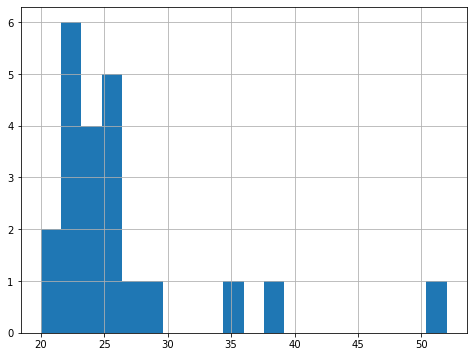

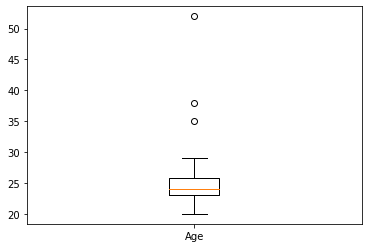

IQR: 2.75
Population Standard Deviation:
6.9317809238939105
Confidence Interval (95%):
(23.217932170726616, 29.50934055654611)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.667, p=0.000
Sample does not look Gaussian (reject H0)


In [5]:
data_demographics_age = data_demographics['Age']
print_stats(data_demographics_age, hist_bins=20)
boxplot(data_demographics_age, ['Age'])
print('Population Standard Deviation:')
print(data_demographics_age.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_demographics_age))
print('Normality Tests:')
normality_tests(data_demographics_age)

### Gender

--- Statistics ----


count       22
unique       2
top       Male
freq        18
Name: Gender, dtype: object



--- Counting Unique Values ----


Male      18
Female     4
Name: Gender, dtype: int64



--- Basic Bar Chart ----


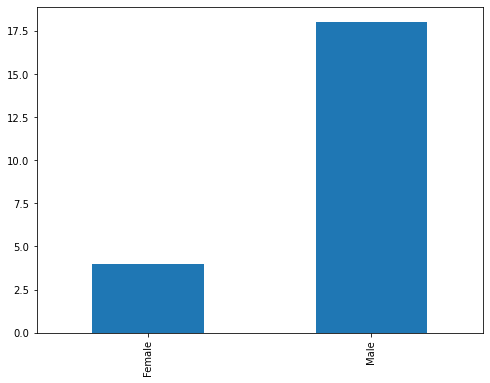

In [6]:
data_demographics_genre = data_demographics['Gender']
print_stats(data_demographics_genre);

### Education

--- Statistics ----


count                    22
unique                    5
top       Bachelor's Degree
freq                     14
Name: Education, dtype: object



--- Counting Unique Values ----


Bachelor's Degree           14
Master's Degree              3
Post-Secondary Education     2
Secondary Education          2
Doctoral Degree              1
Name: Education, dtype: int64



--- Basic Bar Chart ----


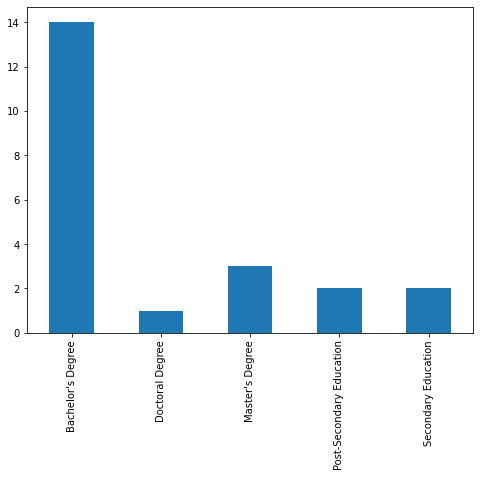

In [7]:
data_demographics_education = data_demographics['Education']
print_stats(data_demographics_education);

### Education Area

--- Statistics ----


count                   22
unique                   2
top       Computer Science
freq                    21
Name: Education Area, dtype: object



--- Counting Unique Values ----


Computer Science            21
Electrical Engineering\n     1
Name: Education Area, dtype: int64



--- Basic Bar Chart ----


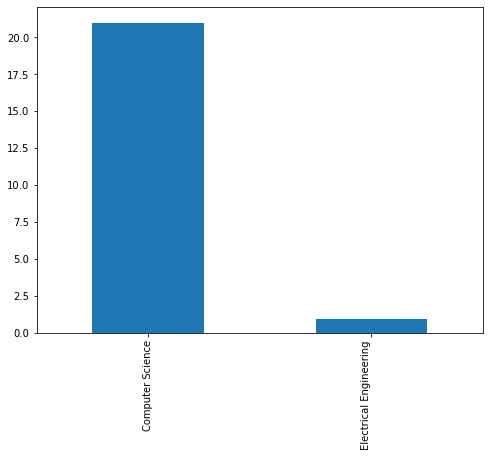

In [8]:
data_demographics_education_area = data_demographics['Education Area']
print_stats(data_demographics_education_area);

### Devices Owned

In [9]:
data_demographics_devices_owned = data_demographics['Devices Owned']
data_demographics_devices_owned_list = data_demographics_devices_owned.map(lambda x: [i.strip() for i in x.split(",")])

print('--- Statistics ----')
display(data_demographics_devices_owned_list.describe())
print('--- Counting Unique Values ----')
display(data_demographics_devices_owned.value_counts())

--- Statistics ----


count                                                  22
unique                                                 16
top       [Desktop computer, Laptop computer, Smartphone]
freq                                                    3
Name: Devices Owned, dtype: object

--- Counting Unique Values ----


Desktop computer, Laptop computer, Smartphone                                                                  3
Laptop computer, Smartphone, Smart TV                                                                          3
Laptop computer, Smartphone                                                                                    2
Desktop computer, Laptop computer, Smartphone, Smart TV, Smartwatch                                            2
Desktop computer, Laptop computer, Smartphone, Tablet, Smart TV, Smartwatch                                    1
Laptop computer, Smartphone, Tablet, Smartwatch, Smart speaker                                                 1
Desktop computer, Laptop computer, Smartphone, Tablet, Smart TV, Smartwatch, Fitness tracker                   1
Laptop computer, Smartphone, Tablet, Smart TV, Fitness tracker                                                 1
Desktop computer, Laptop computer, Smartphone, Tablet, Fitness tracker                          

#### Number of Devices Owned

In [10]:
mlb_devices_owned = MultiLabelBinarizer()
devices_owned_one_hot = pd.DataFrame(mlb_devices_owned.fit_transform(data_demographics_devices_owned_list),
                                     columns=mlb_devices_owned.classes_,index=data_demographics_devices_owned_list.index)
devices_owned_one_hot

,Desktop computer,Fitness tracker,Laptop computer,Smart TV,Smart speaker,Smartphone,Smartwatch,Tablet
0,1,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0,0
2,1,0,1,1,0,1,1,1
3,0,0,1,1,0,1,0,0
4,1,0,1,0,0,1,0,0
5,0,0,1,0,1,1,1,1
6,1,1,1,1,0,1,1,1
7,0,1,1,1,0,1,0,1
8,1,1,1,0,0,1,0,1
9,1,0,1,1,0,1,0,0


In [11]:
num_devices_owned = devices_owned_one_hot.sum(axis=1)
num_devices_owned

0     3
1     2
2     6
3     3
4     3
5     5
6     7
7     5
8     5
9     4
10    4
11    4
12    3
13    3
14    8
15    3
16    5
17    2
18    3
19    3
20    5
21    5
dtype: int64

--- Statistics ----


count    22.000000
mean      4.136364
std       1.552125
min       2.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       8.000000
dtype: float64



--- Counting Unique Values ----


3    8
5    6
4    3
2    2
6    1
7    1
8    1
dtype: int64



--- Basic Bar Chart ----


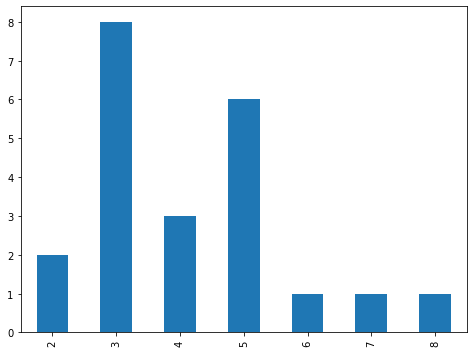

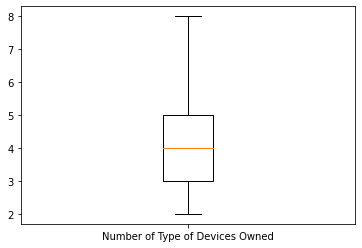

IQR: 2.0
Population Standard Deviation:
1.5164388470556616
Confidence Interval (95%):
(3.4481901219597035, 4.82453715076757)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.898, p=0.027
Sample does not look Gaussian (reject H0)


In [12]:
print_stats(num_devices_owned)
boxplot(num_devices_owned, ['Number of Type of Devices Owned'])
print('Population Standard Deviation:')
print(num_devices_owned.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(num_devices_owned))
print('Normality Tests:')
normality_tests(num_devices_owned)

##### Device Types Owned

In [13]:
device_types_owned = devices_owned_one_hot.sum().sort_values(ascending=False)
device_types_owned

Smartphone          22
Laptop computer     21
Desktop computer    13
Smart TV            12
Smartwatch           8
Tablet               8
Fitness tracker      5
Smart speaker        2
dtype: int64

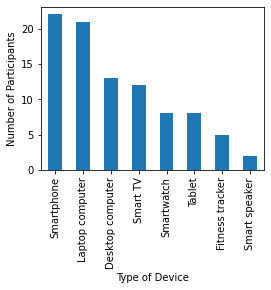

In [14]:
device_types_owned.plot(kind='bar', xlabel='Type of Device', ylabel='Number of Participants', figsize=(4,3))
plt.savefig('out/yanux-skeletron-device-types-owned.pdf', bbox_inches='tight')

##### Percentage of Participants that Own Each Type of Device

In [15]:
(devices_owned_one_hot.sum()/devices_owned_one_hot.count()*100).sort_values(ascending=False)

Smartphone          100.000000
Laptop computer      95.454545
Desktop computer     59.090909
Smart TV             54.545455
Smartwatch           36.363636
Tablet               36.363636
Fitness tracker      22.727273
Smart speaker         9.090909
dtype: float64

### Usage of Multiple Devices

--- Statistics ----


count    22.000000
mean      5.727273
std       1.420323
min       2.000000
25%       5.000000
50%       6.000000
75%       7.000000
max       7.000000
Name: Usage of Multiple Devices, dtype: float64



--- Counting Unique Values ----


7    9
5    6
6    4
3    1
2    1
4    1
Name: Usage of Multiple Devices, dtype: int64



--- Basic Bar Chart ----


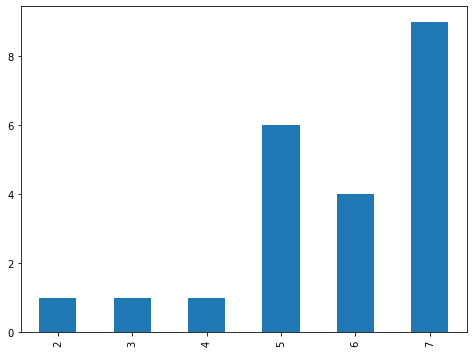

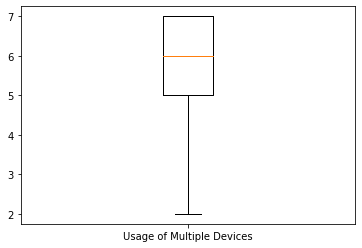

IQR: 2.0
Population Standard Deviation:
1.3876670474976136
Confidence Interval (95%):
(5.097537007462385, 6.35700844708307)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.829, p=0.001
Sample does not look Gaussian (reject H0)


In [16]:
data_demographics_usage_multiple_devices = data_demographics['Usage of Multiple Devices']
print_stats(data_demographics_usage_multiple_devices)
boxplot(data_demographics_usage_multiple_devices, ['Usage of Multiple Devices'])
print('Population Standard Deviation:')
print(data_demographics_usage_multiple_devices.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_demographics_usage_multiple_devices))
print('Normality Tests:')
normality_tests(data_demographics_usage_multiple_devices)

### Response Frequency

In [17]:
data_demographics_usage_multiple_devices_freq = (pd.DataFrame({'Usage of Multiple Devices': data_demographics_usage_multiple_devices.value_counts()}).sort_index().transpose() / data_demographics_usage_multiple_devices.count()) * 100
data_demographics_usage_multiple_devices_freq

,2,3,4,5,6,7
Usage of Multiple Devices,4.545455,4.545455,4.545455,27.272727,18.181818,40.909091


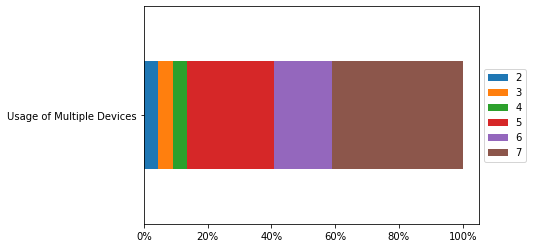

In [18]:
plot_freq(data_demographics_usage_multiple_devices_freq)

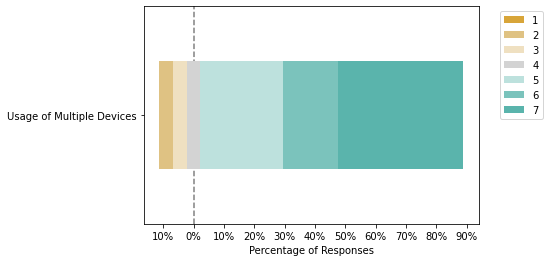

In [19]:
plot_likert.plot_likert(pd.DataFrame(data_demographics_usage_multiple_devices), np.arange(1,8), plot_percentage=True, colors=plot_likert.colors.likert7);

#### Percentage of Users that Use Multiple Devices Sometimes or More Often

In [20]:
(data_demographics_usage_multiple_devices[data_demographics_usage_multiple_devices >= 5].count()/data_demographics_usage_multiple_devices.count())*100

86.36363636363636

## Programming Experience

In [21]:
data_programming_experience = data['Programming Experience']
data_programming_experience

,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Experience with Programming Languages
0,30,6,6,"C, C++, C#, Delphi/Pascal, Java, Perl, PHP, Py..."
1,5,6,6,"C#, Dart, Java, Kotlin, Matlab, PHP, TypeScript"
2,6,4,4,"C++, C#, Java, Kotlin"
3,5,6,5,"C, C++, Java, Python, Ruby"
4,7,5,5,"C, C#, Dart, Java, Matlab, PHP, Python, R, Vis..."
5,5,4,4,"C, C#, Java, Python"
6,20,7,7,"C, C#, Java, PHP, Python, Visual Basic/Visual ..."
7,6,5,5,"C, C#, Dart, Java, Python, TypeScript"
8,4,3,3,"C, C++, C#, Java, Python, Visual Basic/Visual ..."
9,6,5,5,"C, C#, Java, Kotlin, Matlab, PHP, Python"


### Years of Programming Experience

--- Statistics ----


count    22.000000
mean      8.500000
std       6.822582
min       3.000000
25%       5.000000
50%       6.500000
75%       8.000000
max      30.000000
Name: Years of Programming Experience, dtype: float64



--- Counting Unique Values ----


6     4
7     4
5     3
8     3
4     2
3     2
30    1
20    1
9     1
23    1
Name: Years of Programming Experience, dtype: int64



--- Basic Histogram ----


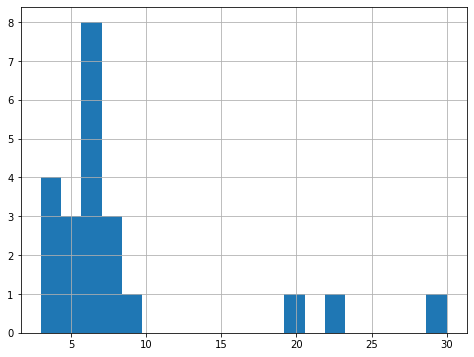

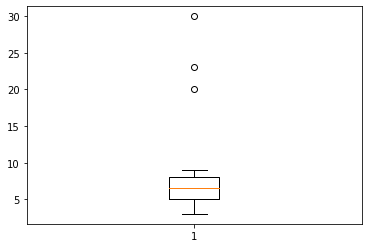

IQR: 3.0
Population Standard Deviation:
6.665719629703771
Confidence Interval (95%):
(5.475036802498799, 11.5249631975012)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.661, p=0.000
Sample does not look Gaussian (reject H0)


In [22]:
data_programming_experience_years = data_programming_experience['Years of Programming Experience']
print_stats(data_programming_experience_years, hist_bins=20)
boxplot(data_programming_experience_years)
print('Population Standard Deviation:')
print(data_programming_experience_years.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_programming_experience_years))
print('Normality Tests:')
normality_tests(data_programming_experience_years)

### Programming Experience (Self Assessment)

--- Statistics ----


count    22.000000
mean      5.227273
std       1.151885
min       3.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       7.000000
Name: Programming Experience (Self Assessment), dtype: float64



--- Counting Unique Values ----


6    7
4    6
5    5
7    3
3    1
Name: Programming Experience (Self Assessment), dtype: int64



--- Basic Bar Chart ----


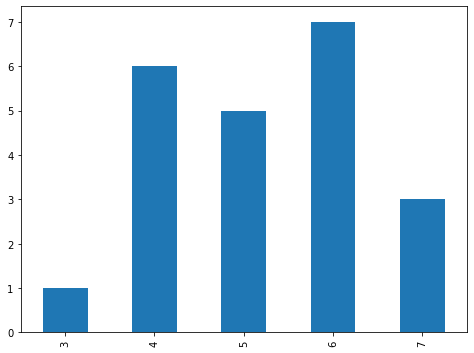

Population Standard Deviation:
1.1254016730127225
Confidence Interval (95%):
(4.716555380551522, 5.737990073993933)


In [23]:
data_programming_experience_self = data_programming_experience['Programming Experience (Self Assessment)']
print_stats(data_programming_experience_self)
print('Population Standard Deviation:')
print(data_programming_experience_self.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_programming_experience_self))

### JavaScript Experience (Self Assessment)

--- Statistics ----


count    22.000000
mean      4.545455
std       1.335496
min       1.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       7.000000
Name: JavaScript Experience (Self Assessment), dtype: float64



--- Counting Unique Values ----


5    7
4    6
6    4
3    3
7    1
1    1
Name: JavaScript Experience (Self Assessment), dtype: int64



--- Basic Bar Chart ----


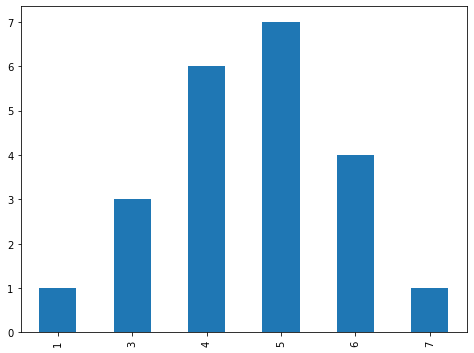

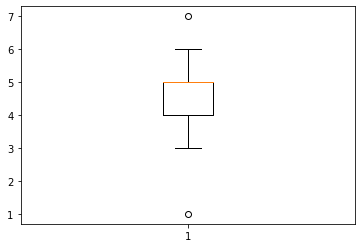

IQR: 1.0
Population Standard Deviation:
1.304790917673393
Confidence Interval (95%):
(3.953328754743598, 5.137580336165494)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.932, p=0.137
Sample looks Gaussian (fail to reject H0)


In [24]:
data_programming_experience_javascript = data_programming_experience['JavaScript Experience (Self Assessment)']
print_stats(data_programming_experience_javascript)
boxplot(data_programming_experience_javascript)
print('Population Standard Deviation:')
print(data_programming_experience_javascript.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_programming_experience_javascript))
print('Normality Tests:')
normality_tests(data_programming_experience_javascript)

### Response Frequency

In [25]:
data_programming_experience_javascript_freq = (pd.DataFrame({'JavaScript Experience': data_programming_experience_javascript.value_counts()}).sort_index().transpose() / data_programming_experience_javascript.count()) * 100
data_programming_experience_javascript_freq

,1,3,4,5,6,7
JavaScript Experience,4.545455,13.636364,27.272727,31.818182,18.181818,4.545455


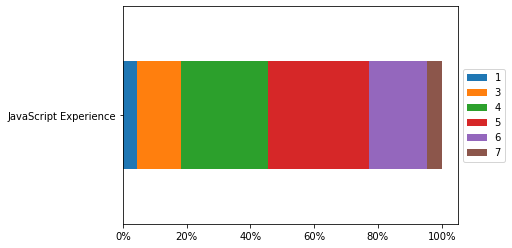

In [26]:
plot_freq(data_programming_experience_javascript_freq)

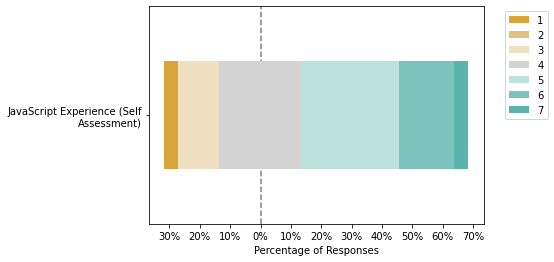

In [27]:
plot_likert.plot_likert(pd.DataFrame(data_programming_experience_javascript), np.arange(1,8), plot_percentage=True, colors=plot_likert.colors.likert7);

### Experience with Programming Languages

In [28]:
data_programming_experience_languages = data_programming_experience['Experience with Programming Languages']
data_programming_experience_languages_list = data_programming_experience_languages.map(lambda x: [i.strip() for i in x.split(",")])

#### Programming Languages

In [29]:
mlb_programming_languages = MultiLabelBinarizer()
programming_languages_one_hot = pd.DataFrame(mlb_programming_languages.fit_transform(data_programming_experience_languages_list),
                                             columns=mlb_programming_languages.classes_,index=data_programming_experience_languages_list.index)
programming_languages_one_hot

,C,C#,C++,Dart,Delphi/Pascal,Java,Kotlin,Matlab,PHP,Perl,Python,R,Ruby,Swift,TypeScript,Visual Basic/Visual Basic for Applications
0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1
1,0,1,0,1,0,1,1,1,1,0,0,0,0,0,1,0
2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,1,1,0,1,0,1,0,1,1,0,1,1,0,0,0,1
5,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
6,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
7,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0
8,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1
9,1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0


In [30]:
num_programming_languages = programming_languages_one_hot.sum(axis=1)
num_programming_languages

0      9
1      7
2      4
3      5
4      9
5      4
6      6
7      6
8      6
9      7
10    11
11    12
12     2
13     5
14     6
15     1
16     7
17     7
18     3
19     6
20     4
21     5
dtype: int64

--- Statistics ----


count    22.000000
mean      6.000000
std       2.654735
min       1.000000
25%       4.250000
50%       6.000000
75%       7.000000
max      12.000000
dtype: float64



--- Counting Unique Values ----


6     5
7     4
4     3
5     3
9     2
11    1
12    1
2     1
1     1
3     1
dtype: int64



--- Basic Bar Chart ----


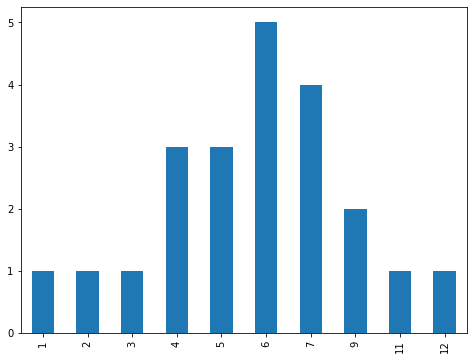

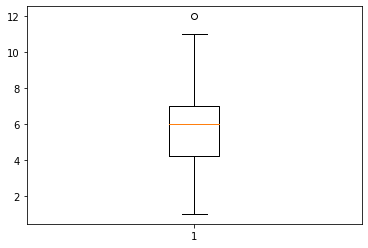

IQR: 2.75
Population Standard Deviation:
2.593698657761292
Confidence Interval (95%):
(4.822956346652575, 7.177043653347425)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.962, p=0.530
Sample looks Gaussian (fail to reject H0)


In [31]:
print_stats(num_programming_languages)
boxplot(num_programming_languages)
print('Population Standard Deviation:')
print(num_programming_languages.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(num_programming_languages))
print('Normality Tests:')
normality_tests(num_programming_languages)

##### How Many Participants Know Each Programming Language

In [32]:
participants_programming_language = programming_languages_one_hot.rename({'Visual Basic/Visual Basic for Applications': 'Visual Basic'}, axis=1).sum().sort_values(ascending=False)
participants_programming_language

Java             21
C#               18
Python           17
C                16
PHP              11
C++              10
TypeScript        8
Kotlin            7
Dart              6
Matlab            6
Visual Basic      6
Ruby              2
Delphi/Pascal     1
Perl              1
R                 1
Swift             1
dtype: int64

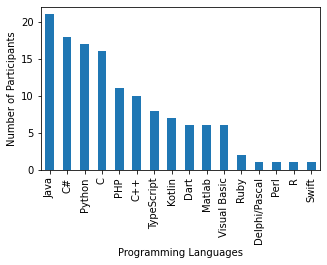

In [33]:
participants_programming_language.plot(kind='bar', xlabel='Programming Languages', ylabel='Number of Participants', figsize=(5,3))
plt.savefig('out/yanux-skeletron-programming-languages.pdf', bbox_inches='tight')

##### Percentage of Participants that Know Each Programming Language

In [34]:
(programming_languages_one_hot.sum()/programming_languages_one_hot.count()*100).sort_values(ascending=False)

Java                                          95.454545
C#                                            81.818182
Python                                        77.272727
C                                             72.727273
PHP                                           50.000000
C++                                           45.454545
TypeScript                                    36.363636
Kotlin                                        31.818182
Dart                                          27.272727
Matlab                                        27.272727
Visual Basic/Visual Basic for Applications    27.272727
Ruby                                           9.090909
Delphi/Pascal                                  4.545455
Perl                                           4.545455
R                                              4.545455
Swift                                          4.545455
dtype: float64

## Sample Plot

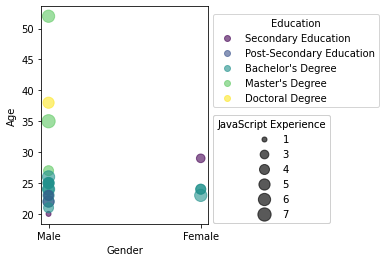

In [35]:
education_levels = ['Basic Education','Secondary Education','Post-Secondary Education', 'Bachelor\'s Degree', 'Master\'s Degree', 'Doctoral Degree']
data_education = data_demographics['Education'].copy().replace(education_levels, range(1,len(education_levels)+1))

fig, ax = plt.subplots(figsize=(3,4))

scatter = ax.scatter(data_demographics['Gender'] ,data_demographics['Age'], c=data_education, s=data_programming_experience_javascript*25, alpha=0.6)

handles, labels = scatter.legend_elements()
legend1 = ax.legend(handles, [x for x in education_levels if x in data_demographics['Education'].unique()] , loc='center left', title='Education', bbox_to_anchor=(1.0, 0.75))
ax.add_artist(legend1)

handles, labels = scatter.legend_elements(prop='sizes')
legend2 = ax.legend(handles, np.sort(data_programming_experience_javascript.unique()) , loc='center left', title='JavaScript Experience',  bbox_to_anchor=(1.0, 0.25))
ax.add_artist(legend2)

plt.xlabel('Gender')
plt.ylabel('Age')

plt.savefig('out/yanux-skeletron-demographics.pdf', bbox_inches='tight')

## Domain Specific Questions

- **DS1:** It makes sense that the UI state of an application is represented by an object.
- **DS2:** I understood how to save the UI state of an application every time it changes.
- **DS3:** I understood how to use the "Coordinator" API to perform various tasks that make my multi-device application behave properly?
- **DS4:** I understood how the DSL (Domain Specific Language) for the automatic distribution of UI components works.
- **DS5:** I understood how to use the "ComponentsRuleEngine" to determine the appropriate distribution of UI components based on the restrictions placed on them and the proxemics relationships between devices currently running application instances.
- **DS6:** I understood how the custom "YanuX Resource Management Element" can be used to manage multiple application states of an application.
- **DS7:** I understood how the custom "YanuX Components Distribution Element" can be used to manage the distribution of UI components of an application.	
- **DS8:** It makes sense to distribute the UI components of an application depending on how closely related the surrounding devices are.

In [36]:
data_domain_specific = data['Domain Specific']
data_domain_specific

,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
0,7,7,7,7,7,7,7,7
1,7,6,6,6,5,6,6,5
2,5,7,6,6,6,6,6,7
3,7,6,6,6,6,6,6,7
4,6,6,6,6,6,6,6,6
5,7,6,6,5,5,6,5,6
6,7,6,7,7,7,7,6,7
7,7,7,7,7,6,6,7,6
8,7,6,6,5,7,7,6,7
9,6,7,6,6,5,5,5,6


--- Statistics ----


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
count,22.000000,22.000000,22.000000,22.00000,22.000000,22.000000,22.000000,22.000000
mean,6.409091,6.045455,6.181818,5.50000,5.590909,6.000000,6.000000,6.545455
std,0.854071,1.396502,0.664499,1.05785,0.908116,1.069045,0.755929,0.595801
min,4.000000,2.000000,5.000000,3.00000,4.000000,2.000000,4.000000,5.000000
25%,6.000000,6.000000,6.000000,5.00000,5.000000,6.000000,6.000000,6.000000
50%,7.000000,6.000000,6.000000,6.00000,5.500000,6.000000,6.000000,7.000000
75%,7.000000,7.000000,7.000000,6.00000,6.000000,6.750000,6.000000,7.000000
max,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


DS1  DS2  DS3  DS4  DS5  DS6  DS7  DS8
4    2    5    5    4    2    4    7      1
5    6    5    3    5    6    6    6      1
7    7    7    7    6    6    7    6      1
               5    5    6    6    7      1
          6    5    6    6    6    7      1
     6    7    7    7    7    6    7      1
               3    7    7    7    7      1
          6    6    6    6    6    7      1
                    5    7    6    7      1
                         6    6    5      1
               5    7    7    6    7      1
                    5    6    5    7      1
                                   6      1
     2    5    6    4    5    6    6      1
6    7    7    6    6    6    6    6      1
          6    6    5    6    6    7      1
                         5    5    6      1
               5    6    7    7    6      1
     6    7    5    5    6    7    7      1
          6    6    6    6    6    6      1
5    7    6    6    6    6    6    7      1
7    7    7    7    7    7    7    7 



--- Basic Histogram ----


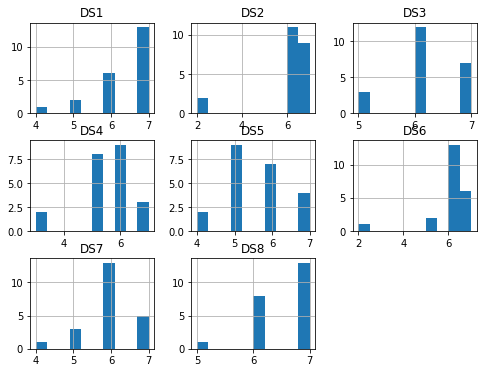

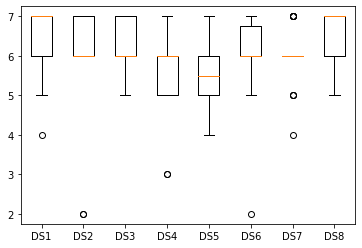

IQR: DS1    1.00
DS2    1.00
DS3    1.00
DS4    1.00
DS5    1.00
DS6    0.75
DS7    0.00
DS8    1.00
dtype: float64
---- Question DS1 ----
Population Standard Deviation:
0.8344345341220828
Confidence Interval (95%):
(6.030417052903601, 6.787764765278217)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.720, p=0.000
Sample does not look Gaussian (reject H0)


---- Question DS2 ----
Population Standard Deviation:
1.3643937290730574
Confidence Interval (95%):
(5.426280465741439, 6.664628625167652)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.595, p=0.000
Sample does not look Gaussian (reject H0)


---- Question DS3 ----
Population Standard Deviation:
0.6492207662311681
Confidence Interval (95%):
(5.88719599036695, 6.476440373269413)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.793, p=0.000
Sample does not look Gaussian (reject H0)


---- Question DS4 ----
Population Standard Deviation:
1.0335288182638247
Confidence Interval (95%):
(5.0309753766310275, 5.9690246233689725)
Normality Te

In [37]:
print_stats(data_domain_specific, hist_bins=10)
boxplot(data_domain_specific)

for column in data_domain_specific:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_domain_specific[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_domain_specific[column]))
    print('Normality Tests:')
    normality_tests(data_domain_specific[column])
    print('\n')

### Response Frequency

In [38]:
data_domain_specific_freq = (data_domain_specific.apply(pd.value_counts).fillna(0)/data_domain_specific.count()*100).transpose()
data_domain_specific_freq

,2,3,4,5,6,7
DS1,0.000000,0.000000,4.545455,9.090909,27.272727,59.090909
DS2,9.090909,0.000000,0.000000,0.000000,50.000000,40.909091
DS3,0.000000,0.000000,0.000000,13.636364,54.545455,31.818182
DS4,0.000000,9.090909,0.000000,36.363636,40.909091,13.636364
DS5,0.000000,0.000000,9.090909,40.909091,31.818182,18.181818
DS6,4.545455,0.000000,0.000000,9.090909,59.090909,27.272727
DS7,0.000000,0.000000,4.545455,13.636364,59.090909,22.727273
DS8,0.000000,0.000000,0.000000,4.545455,36.363636,59.090909


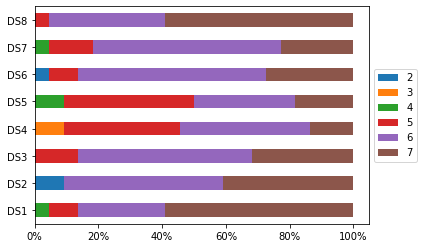

In [39]:
plot_freq(data_domain_specific_freq)

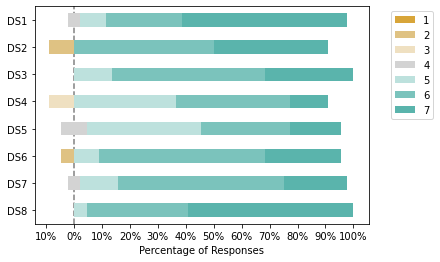

In [40]:
plot_likert.plot_likert(data_domain_specific, np.arange(1,8), plot_percentage=True, colors=plot_likert.colors.likert7);

### Correlation

In [41]:
calculate_correlation(data_domain_specific);

Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
DS1,1.000000,-0.101452,0.309385,0.153912,0.238004,0.357664,0.137192,0.129907
DS2,-0.101452,1.000000,0.428582,0.225880,0.315047,0.130438,0.286740,-0.007586
DS3,0.309385,0.428582,1.000000,0.250657,0.521341,0.438894,0.519576,0.210908
DS4,0.153912,0.225880,0.250657,1.000000,0.200015,0.020076,0.132395,-0.112091
DS5,0.238004,0.315047,0.521341,0.200015,1.000000,0.680955,0.483960,0.214560
DS6,0.357664,0.130438,0.438894,0.020076,0.680955,1.000000,0.534327,0.282739
DS7,0.137192,0.286740,0.519576,0.132395,0.483960,0.534327,1.000000,0.037796
DS8,0.129907,-0.007586,0.210908,-0.112091,0.214560,0.282739,0.037796,1.000000


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
DS1,1.000000,0.614372,0.121122,0.428544,0.218528,0.071746,0.486958,0.524671
DS2,0.614372,1.000000,0.034167,0.251723,0.108101,0.517116,0.151795,0.970769
DS3,0.121122,0.034167,1.000000,0.199464,0.007313,0.027881,0.008795,0.304056
DS4,0.428544,0.251723,0.199464,1.000000,0.290833,0.917754,0.493119,0.574874
DS5,0.218528,0.108101,0.007313,0.290833,1.000000,0.000431,0.011803,0.280534
DS6,0.071746,0.517116,0.027881,0.917754,0.000431,1.000000,0.006780,0.166178
DS7,0.486958,0.151795,0.008795,0.493119,0.011803,0.006780,1.000000,0.852219
DS8,0.524671,0.970769,0.304056,0.574874,0.280534,0.166178,0.852219,1.000000


## UMUX-Lite
- **ULI1:** The YanuX Framework's capabilities meet my requirements.
- **ULI2:** The YanuX Framework is easy to use.

In [42]:
data_umux_lite = data['UMUX-Lite']
data_umux_lite

,ULI1,ULI2
0,7,7
1,4,6
2,6,6
3,7,7
4,7,6
5,6,7
6,6,7
7,6,7
8,7,5
9,7,6


--- Statistics ----


,ULI1,ULI2
count,22.000000,22.000000
mean,5.954545,5.772727
std,0.998917,0.972567
min,4.000000,4.000000
25%,5.000000,5.000000
50%,6.000000,6.000000
75%,7.000000,6.750000
max,7.000000,7.000000




--- Counting Unique Values ----


ULI1  ULI2
5     5       4
6     7       4
7     6       4
6     6       2
7     5       2
      7       2
4     4       1
      6       1
5     4       1
6     5       1
dtype: int64



--- Basic Histogram ----


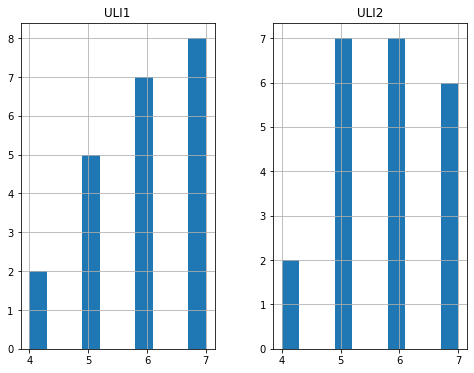

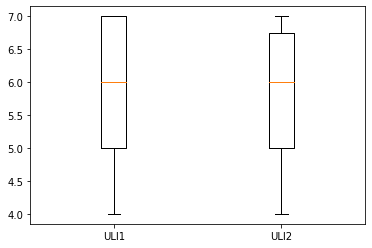

IQR: ULI1    2.00
ULI2    1.75
dtype: float64
---- Question ULI1 ----
Population Standard Deviation:
0.9759504797083586
Confidence Interval (95%):
(5.511650396291612, 6.397440512799296)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.851, p=0.003
Sample does not look Gaussian (reject H0)


---- Question ULI2 ----
Population Standard Deviation:
0.9502065891075852
Confidence Interval (95%):
(5.341515022325236, 6.203939523129309)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.875, p=0.010
Sample does not look Gaussian (reject H0)




In [43]:
print_stats(data_umux_lite, hist_bins=10)
boxplot(data_umux_lite)
for column in data_umux_lite:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_umux_lite[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_umux_lite[column]))
    print('Normality Tests:')
    normality_tests(data_umux_lite[column])
    print('\n')

### Response Frequency

In [44]:
data_umux_lite_freq = (data_umux_lite.apply(pd.value_counts).fillna(0)/data_umux_lite.count()*100).transpose()
data_umux_lite_freq

,4,5,6,7
ULI1,9.090909,22.727273,31.818182,36.363636
ULI2,9.090909,31.818182,31.818182,27.272727


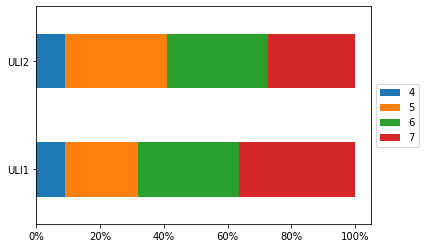

In [45]:
plot_freq(data_umux_lite_freq)

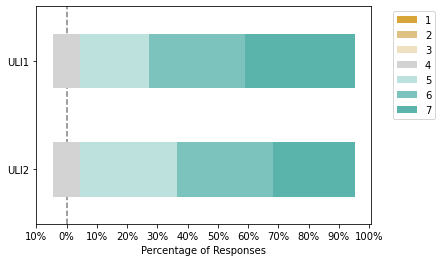

In [46]:
plot_likert.plot_likert(data_umux_lite, np.arange(1,8), plot_percentage=True, colors=plot_likert.colors.likert7);

### Correlation

In [47]:
calculate_correlation(data_umux_lite);

Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,ULI1,ULI2
ULI1,1.000000,0.360471
ULI2,0.360471,1.000000


,ULI1,ULI2
ULI1,1.000000,0.053533
ULI2,0.053533,1.000000


### SUS Conversion

In [48]:
data_umux_lite_sus = 0.65 * ((data_umux_lite['ULI1'] + data_umux_lite['ULI2'] - 2) * (100/12))+22.9
data_umux_lite_sus

0     87.900000
1     66.233333
2     77.066667
3     87.900000
4     82.483333
5     82.483333
6     82.483333
7     82.483333
8     77.066667
9     82.483333
10    66.233333
11    66.233333
12    77.066667
13    60.816667
14    82.483333
15    66.233333
16    66.233333
17    55.400000
18    71.650000
19    82.483333
20    77.066667
21    82.483333
dtype: float64

--- Statistics ----


count    22.000000
mean     75.589394
std       9.183541
min      55.400000
25%      66.233333
50%      77.066667
75%      82.483333
max      87.900000
dtype: float64



--- Counting Unique Values ----


82.483333    8
66.233333    5
77.066667    4
87.900000    2
60.816667    1
55.400000    1
71.650000    1
dtype: int64



--- Basic Bar Chart ----


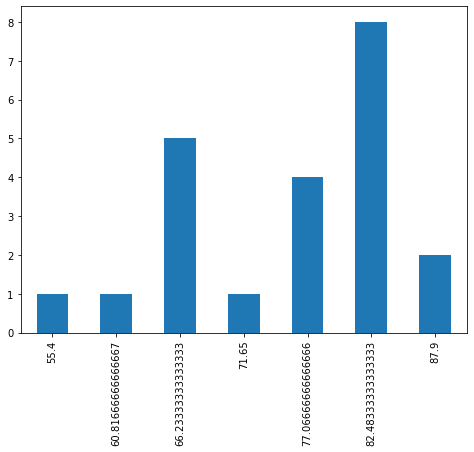

{'describe': count    22.000000
 mean     75.589394
 std       9.183541
 min      55.400000
 25%      66.233333
 50%      77.066667
 75%      82.483333
 max      87.900000
 dtype: float64,
 'value_counts': 82.483333    8
 66.233333    5
 77.066667    4
 87.900000    2
 60.816667    1
 55.400000    1
 71.650000    1
 dtype: int64}

In [49]:
print_stats(data_umux_lite_sus)

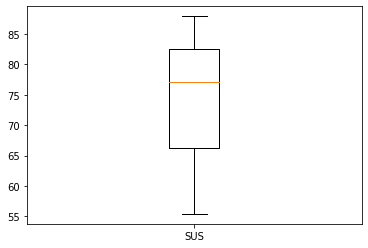

IQR: 16.25


In [50]:
boxplot(data_umux_lite_sus, ['SUS'])

## Semantic Differential Scales
- **SDS1:** Uninteresting/Interesting
- **SDS2:** Complex/Simple
- **SDS3:** Inappropriate/Appropriate
- **SDS4:** Hard to Understand/Easy to Understand
- **SDS5:** Hard to Learn/Easy to Learn
- **SDS6:** Hard to Develop/Easy to Develop

In [51]:
data_sds = data['Semantic Differential Scales']
data_sds

,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
0,7,5,7,7,7,7
1,5,6,6,7,7,7
2,7,2,6,3,6,2
3,7,6,7,6,7,7
4,7,6,7,6,6,6
5,7,7,7,7,7,5
6,7,7,7,7,7,7
7,7,6,6,6,6,6
8,7,5,6,5,5,5
9,7,4,7,4,6,6


--- Statistics ----


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,6.454545,4.909091,6.318182,5.181818,5.636364,5.363636
std,0.595801,1.341963,0.716231,1.296015,1.255292,1.292670
min,5.000000,2.000000,5.000000,3.000000,3.000000,2.000000
25%,6.000000,4.000000,6.000000,4.250000,5.000000,5.000000
50%,6.500000,5.000000,6.000000,5.000000,6.000000,5.500000
75%,7.000000,6.000000,7.000000,6.000000,6.750000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


SDS1  SDS2  SDS3  SDS4  SDS5  SDS6
5     6     6     7     7     7       1
6     2     5     3     5     5       1
7     7     7     7     7     5       1
      6     7     6     7     7       1
                        6     6       1
                  5     6     6       1
            6     6     6     6       1
      5     7     7     7     7       1
            6     5     5     5       1
      4     7     4     6     6       1
                        3     3       1
      2     6     3     6     2       1
6     6     7     6     7     6       1
      5     7     5     6     5       1
            6     6     6     6       1
                  5     5     6       1
            5     5     5     5       1
      4     6     5     6     5       1
                  4     3     4       1
                  3     4     4       1
            5     5     4     5       1
7     7     7     7     7     7       1
dtype: int64



--- Basic Histogram ----


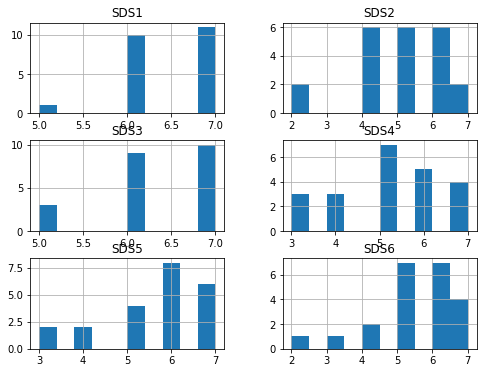

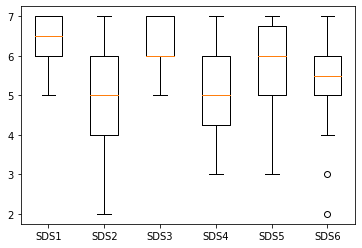

IQR: SDS1    1.00
SDS2    2.00
SDS3    1.00
SDS4    1.75
SDS5    1.75
SDS6    1.00
dtype: float64
---- Question SDS1 ----
Population Standard Deviation:
0.5821022034029865
Confidence Interval (95%):
(6.1903822673283155, 6.718708641762593)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.732, p=0.000
Sample does not look Gaussian (reject H0)


---- Question SDS2 ----
Population Standard Deviation:
1.311109554714178
Confidence Interval (95%):
(4.314097664366209, 5.50408415381561)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.909, p=0.046
Sample does not look Gaussian (reject H0)


---- Question SDS3 ----
Population Standard Deviation:
0.6997638326518479
Confidence Interval (95%):
(6.000622731045671, 6.635740905317966)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.779, p=0.000
Sample does not look Gaussian (reject H0)


---- Question SDS4 ----
Population Standard Deviation:
1.266217116107647
Confidence Interval (95%):
(4.607197527327504, 5.75643883630886)
Normality Tests:
Shapiro-Wilk 

In [52]:
print_stats(data_sds, hist_bins=10)
boxplot(data_sds)
for column in data_sds:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_sds[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_sds[column]))
    print('Normality Tests:')
    normality_tests(data_sds[column])
    print('\n')

### Response Frequency

In [53]:
data_sds_freq = (data_sds.apply(pd.value_counts).fillna(0)/data_sds.count()*100).transpose()
data_sds_freq

,2,3,4,5,6,7
SDS1,0.000000,0.000000,0.000000,4.545455,45.454545,50.000000
SDS2,9.090909,0.000000,27.272727,27.272727,27.272727,9.090909
SDS3,0.000000,0.000000,0.000000,13.636364,40.909091,45.454545
SDS4,0.000000,13.636364,13.636364,31.818182,22.727273,18.181818
SDS5,0.000000,9.090909,9.090909,18.181818,36.363636,27.272727
SDS6,4.545455,4.545455,9.090909,31.818182,31.818182,18.181818


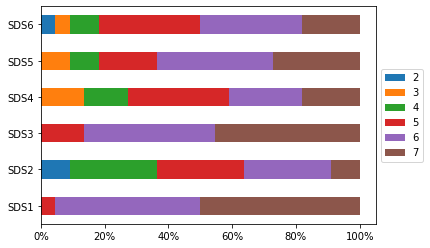

In [54]:
plot_freq(data_sds_freq)

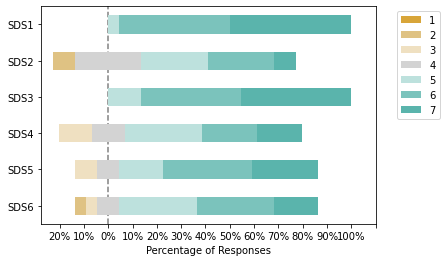

In [55]:
plot_likert.plot_likert(data_sds, np.arange(1,8), plot_percentage=True, colors=plot_likert.colors.likert7);

### Correlation

In [56]:
calculate_correlation(data_sds);

Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
SDS1,1.000000,0.225436,0.533258,0.127443,0.227927,0.116574
SDS2,0.225436,1.000000,0.449950,0.790368,0.587948,0.590173
SDS3,0.533258,0.449950,1.000000,0.336861,0.491807,0.317914
SDS4,0.127443,0.790368,0.336861,1.000000,0.674072,0.686577
SDS5,0.227927,0.587948,0.491807,0.674072,1.000000,0.657469
SDS6,0.116574,0.590173,0.317914,0.686577,0.657469,1.000000


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
SDS1,1.000000,0.245540,0.009261,0.508630,0.242107,0.548434
SDS2,0.245540,1.000000,0.017642,0.000010,0.001123,0.001038
SDS3,0.009261,0.017642,1.000000,0.073662,0.009759,0.093810
SDS4,0.508630,0.000010,0.073662,1.000000,0.000170,0.000122
SDS5,0.242107,0.001123,0.009759,0.000170,1.000000,0.000272
SDS6,0.548434,0.001038,0.093810,0.000122,0.000272,1.000000


### Overall Pseudo-Semantic Differential Scale Score

In [57]:
data_sds_score = data_sds.mean(axis=1)
data_sds_score

0     6.666667
1     6.333333
2     4.333333
3     6.666667
4     6.333333
5     6.666667
6     7.000000
7     6.166667
8     5.500000
9     5.666667
10    5.833333
11    5.166667
12    4.500000
13    4.666667
14    6.166667
15    4.833333
16    4.500000
17    4.333333
18    5.333333
19    5.666667
20    5.500000
21    6.333333
dtype: float64

--- Statistics ----


count    22.000000
mean      5.643939
std       0.845617
min       4.333333
25%       4.916667
50%       5.666667
75%       6.333333
max       7.000000
dtype: float64



--- Counting Unique Values ----


6.666667    3
6.333333    3
4.333333    2
6.166667    2
5.500000    2
5.666667    2
4.500000    2
7.000000    1
5.833333    1
5.166667    1
4.666667    1
4.833333    1
5.333333    1
dtype: int64



--- Basic Histogram ----


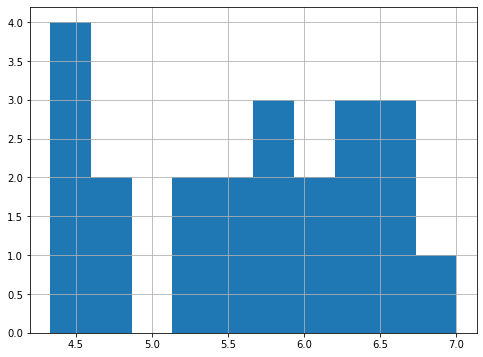

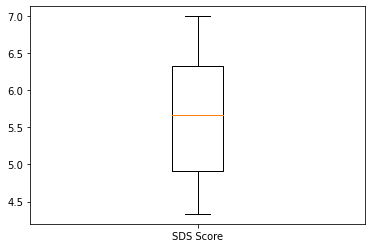

IQR: 1.416666666666667


In [58]:
print_stats(data_sds_score, hist_bins=10)
boxplot(data_sds_score, ['SDS Score'])

## NPS

In [59]:
data_nps = data['NPS']
data_nps

,NPS
0,9
1,8
2,9
3,9
4,8
5,7
6,10
7,10
8,10
9,9


### Calculate NPS

In [60]:
nps_count = data_nps['NPS'].count()
nps_promoters = data_nps['NPS'][data_nps['NPS'] >= 9].count()
nps_detractors = data_nps['NPS'][data_nps['NPS'] <= 6].count()

nps_promoters_per = nps_promoters/nps_count*100
nps_detractors_per = nps_detractors/nps_count*100

nps_score = nps_promoters_per - nps_detractors_per
print('NPS Count', nps_count)
print('NPS Promoters', nps_promoters)
print('NPS Detractors', nps_detractors)
print('NPS Promoters (Percentage)', nps_promoters_per)
print('NPS Detractors (Percentage)', nps_detractors_per)

NPS Count 22
NPS Promoters 9
NPS Detractors 2
NPS Promoters (Percentage) 40.909090909090914
NPS Detractors (Percentage) 9.090909090909092


### General Stats

--- Statistics ----


count    22.000000
mean      8.136364
std       1.283427
min       6.000000
25%       7.000000
50%       8.000000
75%       9.000000
max      10.000000
Name: NPS, dtype: float64



--- Counting Unique Values ----


7     6
9     5
8     5
10    4
6     2
Name: NPS, dtype: int64



--- Basic Bar Chart ----


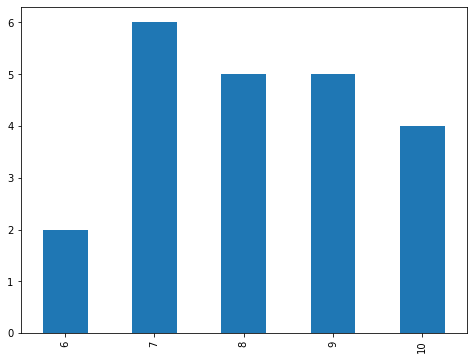

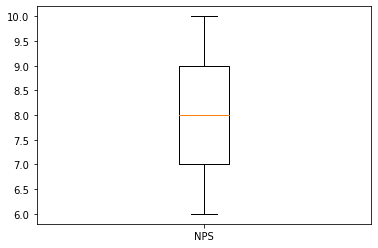

IQR: NPS    2.0
dtype: float64
Population Standard Deviation:
1.2539194749212474
Confidence Interval (95%):
(7.567323761454381, 8.705403511272893)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.912, p=0.051
Sample looks Gaussian (fail to reject H0)




In [61]:
print_stats(data_nps['NPS'])
boxplot(data_nps)
print('Population Standard Deviation:')
print(data_nps['NPS'].std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_nps['NPS']))
print('Normality Tests:')
normality_tests(data_nps['NPS'])
print('\n')

### Response Frequency

In [62]:
data_nps_freq = (data_nps.apply(pd.value_counts).fillna(0)/data_nps.count()*100).transpose()
data_nps_freq

,7,9,8,10,6
NPS,27.272727,22.727273,22.727273,18.181818,9.090909


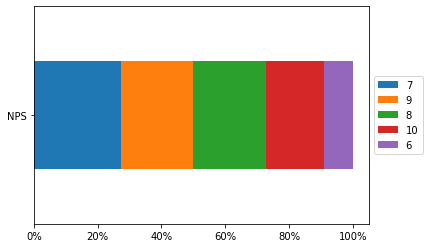

In [63]:
plot_freq(data_nps_freq)

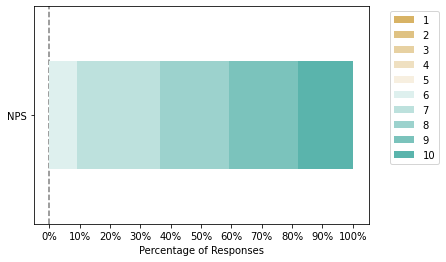

In [64]:
plot_likert.plot_likert(data_nps, np.arange(1,11), plot_percentage=True, colors=plot_likert.colors.likert10);

## NASA TLX

In [65]:
data_nasa_tlx = data['NASA TLX']
data_nasa_tlx['NASA TLX Score'] = data_nasa_tlx.mean(axis=1)
data_nasa_tlx

,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
0,60,20,35,10,30,15,28.333333
1,45,0,45,15,25,5,22.500000
2,75,35,50,30,70,35,49.166667
3,65,0,85,10,40,15,35.833333
4,15,5,5,10,90,0,20.833333
5,45,0,75,60,85,10,45.833333
6,10,0,10,15,35,5,12.500000
7,10,0,0,5,5,0,3.333333
8,30,0,5,25,10,10,13.333333
9,10,10,15,15,35,15,16.666667


--- Statistics ----


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,45.909091,7.954545,33.636364,22.500000,37.272727,13.181818,26.742424
std,22.127141,9.469134,27.867963,16.384517,24.915441,15.625487,13.709739
min,10.000000,0.000000,0.000000,5.000000,5.000000,0.000000,3.333333
25%,30.000000,0.000000,11.250000,15.000000,20.000000,5.000000,16.041667
50%,47.500000,5.000000,25.000000,15.000000,32.500000,10.000000,22.916667
75%,65.000000,15.000000,50.000000,25.000000,45.000000,15.000000,34.583333
max,75.000000,35.000000,85.000000,65.000000,90.000000,65.000000,52.500000




--- Counting Unique Values ----


Mental Demand  Physical Demand  Temporal Demand  Performance  Effort  Frustration  NASA TLX Score
10             0                0                5            5       0            3.333333          1
                                10               15           35      5            12.500000         1
75             0                50               50           75      65           52.500000         1
70             15               80               15           20      10           35.000000         1
               10               60               25           25      10           33.333333         1
65             15               70               65           45      40           50.000000         1
               5                15               15           20      0            20.000000         1
               0                85               10           40      15           35.833333         1
60             20               35               10           30      15      



--- Basic Histogram ----


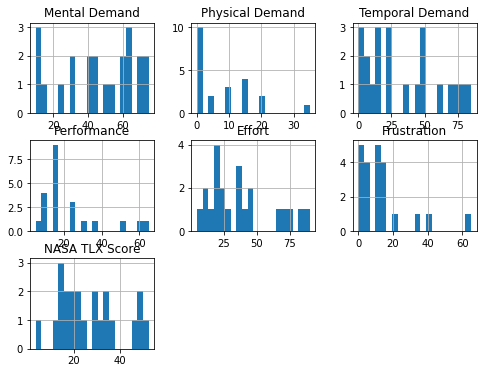

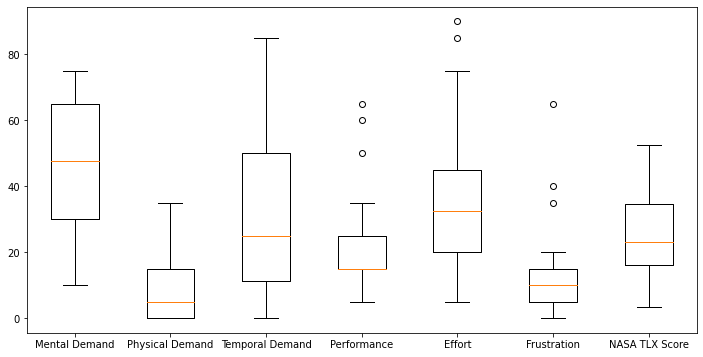

IQR: Mental Demand      35.000000
Physical Demand    15.000000
Temporal Demand    38.750000
Performance        10.000000
Effort             25.000000
Frustration        10.000000
NASA TLX Score     18.541667
dtype: float64
---- Question Mental Demand ----
Population Standard Deviation:
21.618403546534754
Confidence Interval (95%):
(36.09846598787692, 55.71971583030489)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.915, p=0.060
Sample looks Gaussian (fail to reject H0)


---- Question Physical Demand ----
Population Standard Deviation:
9.251423835021646
Confidence Interval (95%):
(3.7561665577316408, 12.152924351359268)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.812, p=0.001
Sample does not look Gaussian (reject H0)


---- Question Temporal Demand ----
Population Standard Deviation:
27.227234785221704
Confidence Interval (95%):
(21.280400924100505, 45.99232634862676)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.914, p=0.058
Sample looks Gaussian (fail to reject H0)


---- Ques

In [66]:
print_stats(data_nasa_tlx, hist_bins=20)
boxplot(data_nasa_tlx, plt_size=(12,6))
for column in data_nasa_tlx:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_nasa_tlx[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_nasa_tlx[column]))
    print('Normality Tests:')
    normality_tests(data_nasa_tlx[column])
    print('\n')

### Correlation

In [67]:
calculate_correlation(data_nasa_tlx);

Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
Mental Demand,1.000000,0.188999,0.508010,0.331968,0.232877,0.507759,0.659441
Physical Demand,0.188999,1.000000,0.163833,0.000000,0.000000,0.112531,0.189409
Temporal Demand,0.508010,0.163833,1.000000,0.322796,0.237987,0.422501,0.665417
Performance,0.331968,0.000000,0.322796,1.000000,0.297285,0.462601,0.401289
Effort,0.232877,0.000000,0.237987,0.297285,1.000000,0.440696,0.463391
Frustration,0.507759,0.112531,0.422501,0.462601,0.440696,1.000000,0.584278
NASA TLX Score,0.659441,0.189409,0.665417,0.401289,0.463391,0.584278,1.000000


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
Mental Demand,1.000000,0.266332,0.001546,0.047449,0.145836,0.002170,0.000027
Physical Demand,0.266332,1.000000,0.335949,1.000000,1.000000,0.522227,0.255665
Temporal Demand,0.001546,0.335949,1.000000,0.054250,0.137732,0.010847,0.000023
Performance,0.047449,1.000000,0.054250,1.000000,0.075629,0.007554,0.014491
Effort,0.145836,1.000000,0.137732,0.075629,1.000000,0.007741,0.003160
Frustration,0.002170,0.522227,0.010847,0.007554,0.007741,1.000000,0.000319
NASA TLX Score,0.000027,0.255665,0.000023,0.014491,0.003160,0.000319,1.000000


## SEQ Exercises

In [68]:
data_seq = data['SEQ']
data_seq

,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
0,6,6,7,7,7,7,6,7,6,7,7
1,6,6,7,7,7,7,7,7,7,7,7
2,6,5,7,7,7,7,7,7,6,7,7
3,6,5,6,7,6,7,5,7,4,6,7
4,6,5,7,7,7,7,6,7,5,7,7
5,3,2,3,7,6,7,4,7,1,7,6
6,7,6,7,7,7,6,7,7,6,7,7
7,6,6,6,7,7,7,6,7,6,7,7
8,5,5,6,7,7,7,6,7,6,7,7
9,5,5,6,5,6,6,5,6,4,5,6


--- Statistics ----


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
count,22.000000,22.0000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,5.590909,5.0000,6.045455,6.818182,6.727273,6.636364,5.909091,6.590909,5.227273,6.590909,6.590909
std,1.053750,0.9759,1.214095,0.501081,0.455842,0.657952,0.811177,0.854071,1.445249,0.796366,0.666125
min,3.000000,2.0000,3.000000,5.000000,6.000000,5.000000,4.000000,4.000000,1.000000,4.000000,5.000000
25%,5.000000,5.0000,6.000000,7.000000,6.250000,6.250000,5.250000,7.000000,5.000000,6.250000,6.000000
50%,6.000000,5.0000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000,6.000000,7.000000,7.000000
75%,6.000000,6.0000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,6.000000,7.000000,7.000000
max,7.000000,6.0000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


Exercise 1  Exercise 2  Exercise 3  Exercise 4  Exercise 5  Exercise 6  Exercise 7  Exercise 8  Exercise 9  Exercise 10  Exercise 11
6           5           7           7           7           7           7           7           6           7            7              2
3           2           3           7           6           7           4           7           1           7            6              1
6           5           6           7           7           7           6           7           5           7            7              1
7           6           6           6           6           6           6           5           6           7            7              1
                        4           7           7           7           6           7           6           7            7              1
6           6           7           7           7           7           7           7           7           7            7              1
                                       



--- Basic Histogram ----


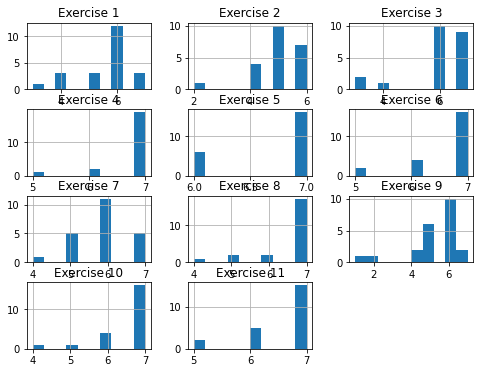

---- Question Exercise 1 ----
Population Standard Deviation:
1.0295228775369203
Confidence Interval (95%):
(5.12370239927794, 6.058115782540241)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.836, p=0.002
Sample does not look Gaussian (reject H0)


---- Question Exercise 2 ----
Population Standard Deviation:
0.9534625892455924
Confidence Interval (95%):
(4.567310147608129, 5.432689852391871)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.808, p=0.001
Sample does not look Gaussian (reject H0)


---- Question Exercise 3 ----
Population Standard Deviation:
1.1861807591545352
Confidence Interval (95%):
(5.507155105730591, 6.5837539851785)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.705, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 4 ----
Population Standard Deviation:
0.48956043701222757
Confidence Interval (95%):
(6.596014912403874, 7.040348723959763)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.423, p=0.000
Sample does not look Gaussian (reject H0)


In [69]:
print_stats(data_seq, hist_bins=10)
for column in data_seq:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_seq[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_seq[column]))
    print('Normality Tests:')
    normality_tests(data_seq[column])
    print('\n')

### Response Frequency

In [70]:
data_seq_freq = (data_seq.apply(pd.value_counts).fillna(0)/data_seq.count()*100).transpose()
data_seq_freq

,1,2,3,4,5,6,7
Exercise 1,0.000000,0.000000,4.545455,13.636364,13.636364,54.545455,13.636364
Exercise 2,0.000000,4.545455,0.000000,18.181818,45.454545,31.818182,0.000000
Exercise 3,0.000000,0.000000,9.090909,4.545455,0.000000,45.454545,40.909091
Exercise 4,0.000000,0.000000,0.000000,0.000000,4.545455,9.090909,86.363636
Exercise 5,0.000000,0.000000,0.000000,0.000000,0.000000,27.272727,72.727273
Exercise 6,0.000000,0.000000,0.000000,0.000000,9.090909,18.181818,72.727273
Exercise 7,0.000000,0.000000,0.000000,4.545455,22.727273,50.000000,22.727273
Exercise 8,0.000000,0.000000,0.000000,4.545455,9.090909,9.090909,77.272727
Exercise 9,4.545455,4.545455,0.000000,9.090909,27.272727,45.454545,9.090909
Exercise 10,0.000000,0.000000,0.000000,4.545455,4.545455,18.181818,72.727273


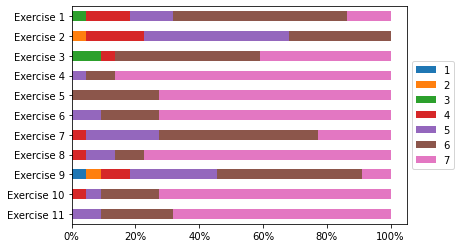

In [71]:
ax = data_seq_freq.iloc[::-1].plot.barh(stacked=True)
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_major_formatter(mtick.PercentFormatter()) 
plt.show()

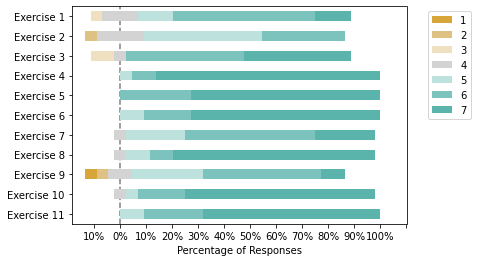

In [72]:
plot_likert.plot_likert(data_seq, np.arange(1,8), plot_percentage=True, colors=plot_likert.colors.likert7);

### Correlation

In [73]:
calculate_correlation(data_seq);

Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
Exercise 1,1.000000,0.577804,-0.032796,0.093811,0.179773,-0.102062,0.358974,0.207556,0.289462,0.304725,0.530087
Exercise 2,0.577804,1.000000,0.071466,-0.103247,-0.024282,-0.139977,0.215883,0.032894,0.457530,0.278618,0.332786
Exercise 3,-0.032796,0.071466,1.000000,0.191979,0.418063,0.152631,0.406664,0.059465,0.296184,0.095939,0.061115
Exercise 4,0.093811,-0.103247,0.191979,1.000000,0.637793,0.600005,0.156352,0.647998,0.020029,0.368449,0.242804
Exercise 5,0.179773,-0.024282,0.418063,0.637793,1.000000,0.500400,0.522976,0.370417,0.227677,0.288847,0.361659
Exercise 6,-0.102062,-0.139977,0.152631,0.600005,0.500400,1.000000,0.062807,0.366053,-0.052800,0.315793,0.164591
Exercise 7,0.358974,0.215883,0.406664,0.156352,0.522976,0.062807,1.000000,0.232463,0.702100,0.375046,0.604747
Exercise 8,0.207556,0.032894,0.059465,0.647998,0.370417,0.366053,0.232463,1.000000,0.215367,0.637536,0.522160
Exercise 9,0.289462,0.457530,0.296184,0.020029,0.227677,-0.052800,0.702100,0.215367,1.000000,0.502964,0.423214
Exercise 10,0.304725,0.278618,0.095939,0.368449,0.288847,0.315793,0.375046,0.637536,0.502964,1.000000,0.473216


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
Exercise 1,1.000000,0.002348,0.864798,0.637761,0.373904,0.603550,0.058752,0.287784,0.119694,0.119454,0.006896
Exercise 2,0.002348,1.000000,0.714060,0.608888,0.905604,0.481882,0.261647,0.867877,0.015136,0.159777,0.093949
Exercise 3,0.864798,0.714060,1.000000,0.348277,0.044147,0.449622,0.037075,0.766848,0.120989,0.633178,0.761692
Exercise 4,0.637761,0.608888,0.348277,1.000000,0.003012,0.004079,0.438445,0.001794,0.919253,0.076524,0.244322
Exercise 5,0.373904,0.905604,0.044147,0.003012,1.000000,0.018271,0.010650,0.078628,0.256090,0.171244,0.087496
Exercise 6,0.603550,0.481882,0.449622,0.004079,0.018271,1.000000,0.752341,0.073720,0.786453,0.123748,0.423584
Exercise 7,0.058752,0.261647,0.037075,0.438445,0.010650,0.752341,1.000000,0.239748,0.000193,0.058447,0.002337
Exercise 8,0.287784,0.867877,0.766848,0.001794,0.078628,0.073720,0.239748,1.000000,0.266018,0.001760,0.010604
Exercise 9,0.119694,0.015136,0.120989,0.919253,0.256090,0.786453,0.000193,0.266018,1.000000,0.009551,0.029609
Exercise 10,0.119454,0.159777,0.633178,0.076524,0.171244,0.123748,0.058447,0.001760,0.009551,1.000000,0.020855


### Overall Pseudo-SEQ Score

In [74]:
data_seq_score = data_seq.mean(axis=1)
data_seq_score

0     6.636364
1     6.818182
2     6.636364
3     6.000000
4     6.454545
5     4.818182
6     6.727273
7     6.545455
8     6.363636
9     5.363636
10    6.454545
11    6.181818
12    5.545455
13    6.000000
14    6.000000
15    6.090909
16    6.000000
17    5.181818
18    6.363636
19    6.636364
20    6.181818
21    6.454545
dtype: float64

--- Statistics ----


count    22.000000
mean      6.157025
std       0.525749
min       4.818182
25%       6.000000
50%       6.272727
75%       6.522727
max       6.818182
dtype: float64



--- Counting Unique Values ----


6.000000    4
6.636364    3
6.454545    3
6.363636    2
6.181818    2
6.818182    1
4.818182    1
6.727273    1
6.545455    1
5.363636    1
5.545455    1
6.090909    1
5.181818    1
dtype: int64



--- Basic Bar Chart ----


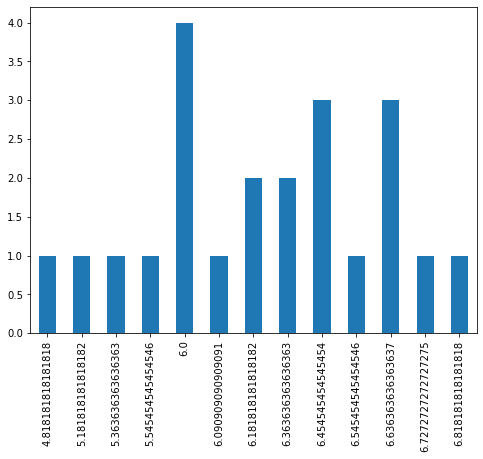

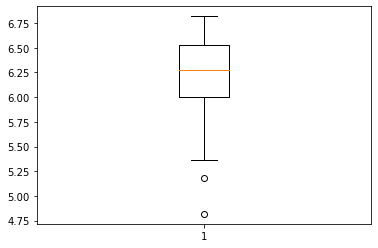

IQR: 0.5227272727272734


In [75]:
print_stats(data_seq_score)
boxplot(data_seq_score)

## Exercises

In [76]:
data_exercises = data['Exercises'].copy()

data_exercises_times = data_exercises.select_dtypes(include='object')
data_exercises_times = data_exercises_times.applymap(convert_time_to_timedelta, na_action='ignore')
data_exercises_times = data_exercises_times / np.timedelta64(1, 's')

data_exercises[data_exercises_times.columns] = data_exercises_times[data_exercises_times.columns]

display(data_exercises)
display(data_exercises.describe())
for column in data_exercises:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_exercises[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_exercises[column]))
    print('Normality Tests:')
    normality_tests(data_exercises[column])
    print('\n')

,Exercise 1 Total Time,Exercise 1 Time First Needed Help,Exercise 1 Times Needed Help,Exercise 1 Number of Errors,Exercise 2 Total Time,Exercise 2 Time First Needed Help,Exercise 2 Times Needed Help,Exercise 2 Number of Errors,Exercise 3 Total Time,Exercise 3 Time First Needed Help,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,86.0,NaN,0,0,336.0,154.0,5,1,48.0,32.0,...,2,1,39.0,NaN,0,0,11.0,NaN,0,0
1,201.0,144.0,1,2,255.0,40.0,3,3,30.0,NaN,...,2,2,31.0,NaN,0,0,20.0,NaN,0,0
2,176.0,93.0,2,0,280.0,13.0,7,5,88.0,17.0,...,1,0,46.0,12.0,1,1,30.0,16.0,1,1
3,104.0,NaN,3,0,358.0,33.0,8,3,12.0,30.0,...,3,1,64.0,37.0,1,1,25.0,NaN,0,0
4,133.0,49.0,3,1,284.0,43.0,5,3,92.0,39.0,...,1,0,38.0,NaN,0,0,24.0,NaN,0,0
5,250.0,51.0,4,0,285.0,74.0,5,2,110.0,33.0,...,4,2,83.0,21.0,2,1,32.0,21.0,1,1
6,169.0,62.0,2,1,196.0,21.0,3,2,82.0,39.0,...,4,0,31.0,31.0,1,1,25.0,NaN,0,0
7,130.0,62.0,1,0,243.0,105.0,5,2,190.0,40.0,...,2,1,58.0,NaN,0,0,32.0,32.0,1,0
8,107.0,217.0,3,0,259.0,14.0,4,3,133.0,97.0,...,3,0,78.0,55.0,1,1,34.0,NaN,0,0


,Exercise 1 Total Time,Exercise 1 Time First Needed Help,Exercise 1 Times Needed Help,Exercise 1 Number of Errors,Exercise 2 Total Time,Exercise 2 Time First Needed Help,Exercise 2 Times Needed Help,Exercise 2 Number of Errors,Exercise 3 Total Time,Exercise 3 Time First Needed Help,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
count,9.000000,7.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,...,9.000000,9.000000,9.00000,5.000000,9.000000,9.000000,9.000000,3.000000,9.000000,9.000000
mean,150.666667,96.857143,2.111111,0.444444,277.333333,55.222222,5.000000,2.666667,87.222222,40.875000,...,2.444444,0.777778,52.00000,31.200000,0.666667,0.555556,25.888889,23.000000,0.333333,0.222222
std,52.896125,62.576429,1.269296,0.726483,48.332184,47.586179,1.658312,1.118034,54.428342,23.865322,...,1.130388,0.833333,19.68502,16.376813,0.707107,0.527046,7.236098,8.185353,0.500000,0.440959
min,86.000000,49.000000,0.000000,0.000000,196.000000,13.000000,3.000000,1.000000,12.000000,17.000000,...,1.000000,0.000000,31.00000,12.000000,0.000000,0.000000,11.000000,16.000000,0.000000,0.000000
25%,107.000000,56.500000,1.000000,0.000000,255.000000,21.000000,4.000000,2.000000,48.000000,31.500000,...,2.000000,0.000000,38.00000,21.000000,0.000000,0.000000,24.000000,18.500000,0.000000,0.000000
50%,133.000000,62.000000,2.000000,0.000000,280.000000,40.000000,5.000000,3.000000,88.000000,36.000000,...,2.000000,1.000000,46.00000,31.000000,1.000000,1.000000,25.000000,21.000000,0.000000,0.000000
75%,176.000000,118.500000,3.000000,1.000000,285.000000,74.000000,5.000000,3.000000,110.000000,39.250000,...,3.000000,1.000000,64.00000,37.000000,1.000000,1.000000,32.000000,26.500000,1.000000,0.000000
max,250.000000,217.000000,4.000000,2.000000,358.000000,154.000000,8.000000,5.000000,190.000000,97.000000,...,4.000000,2.000000,83.00000,55.000000,2.000000,1.000000,34.000000,32.000000,1.000000,1.000000


---- Question Exercise 1 Total Time ----
Population Standard Deviation:
49.870944558040115
Confidence Interval (95%):
(110.0071059649992, 191.32622736833412)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.944, p=0.627
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Time First Needed Help ----
Population Standard Deviation:
57.93451616493665
Confidence Interval (95%):
(38.98359818292664, 154.73068753135908)
Normality Tests:
Shapiro-Wilk Test
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Times Needed Help ----
Population Standard Deviation:
1.1967032904743342
Confidence Interval (95%):
(1.1354442070223274, 3.086778015199895)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.948, p=0.663
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.11397994377763243, 1.0028688326665214)
Normality Tests:
Shapiro-Wil

C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [77]:
data_exercises_seq = pd.concat([data_seq, data_exercises], axis=1)
data_exercises_seq

,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,6,6,7,7,7,7,6,7,6,7,...,2.0,1.0,39.0,NaN,0.0,0.0,11.0,NaN,0.0,0.0
1,6,6,7,7,7,7,7,7,7,7,...,2.0,2.0,31.0,NaN,0.0,0.0,20.0,NaN,0.0,0.0
2,6,5,7,7,7,7,7,7,6,7,...,1.0,0.0,46.0,12.0,1.0,1.0,30.0,16.0,1.0,1.0
3,6,5,6,7,6,7,5,7,4,6,...,3.0,1.0,64.0,37.0,1.0,1.0,25.0,NaN,0.0,0.0
4,6,5,7,7,7,7,6,7,5,7,...,1.0,0.0,38.0,NaN,0.0,0.0,24.0,NaN,0.0,0.0
5,3,2,3,7,6,7,4,7,1,7,...,4.0,2.0,83.0,21.0,2.0,1.0,32.0,21.0,1.0,1.0
6,7,6,7,7,7,6,7,7,6,7,...,4.0,0.0,31.0,31.0,1.0,1.0,25.0,NaN,0.0,0.0
7,6,6,6,7,7,7,6,7,6,7,...,2.0,1.0,58.0,NaN,0.0,0.0,32.0,32.0,1.0,0.0
8,5,5,6,7,7,7,6,7,6,7,...,3.0,0.0,78.0,55.0,1.0,1.0,34.0,NaN,0.0,0.0
9,5,5,6,5,6,6,5,6,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[-------------------------------- [Exercise 1] --------------------------------]


,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
0,6,86.0,0.0,0.0
1,6,201.0,1.0,2.0
2,6,176.0,2.0,0.0
3,6,104.0,3.0,0.0
4,6,133.0,3.0,1.0
5,3,250.0,4.0,0.0
6,7,169.0,2.0,1.0
7,6,130.0,1.0,0.0
8,5,107.0,3.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
Exercise 1,1.000000,-0.109109,-0.470317,0.439155
Exercise 1 Total Time,-0.109109,1.000000,0.149671,0.372678
Exercise 1 Times Needed Help,-0.470317,0.149671,1.000000,-0.160644
Exercise 1 Number of Errors,0.439155,0.372678,-0.160644,1.000000


,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
Exercise 1,1.000000,0.706931,0.122086,0.175699
Exercise 1 Total Time,0.706931,1.000000,0.590493,0.206507
Exercise 1 Times Needed Help,0.122086,0.590493,1.000000,0.603703
Exercise 1 Number of Errors,0.175699,0.206507,0.603703,1.000000


---- Question Exercise 1 ----
Population Standard Deviation:
1.0540925533894598
Confidence Interval (95%):
(4.807269666278297, 6.526063667055037)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.718, p=0.002
Sample does not look Gaussian (reject H0)


---- Question Exercise 1 Total Time ----
Population Standard Deviation:
49.870944558040115
Confidence Interval (95%):
(110.0071059649992, 191.32622736833412)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.944, p=0.627
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Times Needed Help ----
Population Standard Deviation:
1.1967032904743342
Confidence Interval (95%):
(1.1354442070223274, 3.086778015199895)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.948, p=0.663
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.11397994377763243, 1.0028688326665214)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.6

,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
0,0.641936,0.463500,0.579948,0.191693
1,0.119861,0.582184,0.067753,0.801314
2,0.385971,0.359933,0.804732,0.271812
3,0.651596,0.562741,0.107133,0.497260


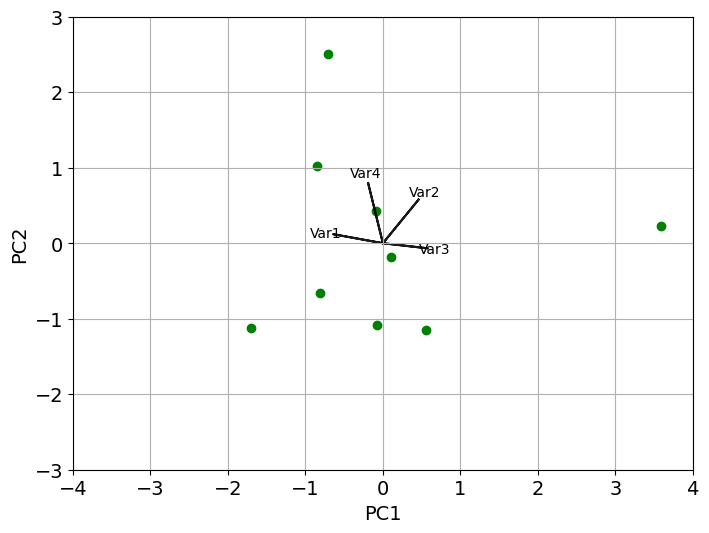

[-------------------------------- [Exercise 2] --------------------------------]


,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
0,6,336.0,5.0,1.0
1,6,255.0,3.0,3.0
2,5,280.0,7.0,5.0
3,5,358.0,8.0,3.0
4,5,284.0,5.0,3.0
5,2,285.0,5.0,2.0
6,6,196.0,3.0,2.0
7,6,243.0,5.0,2.0
8,5,259.0,4.0,3.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
Exercise 2,1.000000,-0.476290,-0.416954,-0.353553
Exercise 2 Total Time,-0.476290,1.000000,0.588035,0.032075
Exercise 2 Times Needed Help,-0.416954,0.588035,1.000000,0.178685
Exercise 2 Number of Errors,-0.353553,0.032075,0.178685,1.000000


,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
Exercise 2,1.000000,0.105193,0.180892,0.266669
Exercise 2 Total Time,0.105193,1.000000,0.036265,0.910794
Exercise 2 Times Needed Help,0.180892,0.036265,1.000000,0.555439
Exercise 2 Number of Errors,0.266669,0.910794,0.555439,1.000000


---- Question Exercise 2 ----
Population Standard Deviation:
1.1967032904743342
Confidence Interval (95%):
(4.135444207022327, 6.0867780151998945)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.685, p=0.001
Sample does not look Gaussian (reject H0)


---- Question Exercise 2 Total Time ----
Population Standard Deviation:
45.56801997502683
Confidence Interval (95%):
(240.18192802812345, 314.48473863854315)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.959, p=0.784
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 2 Times Needed Help ----
Population Standard Deviation:
1.5634719199411433
Confidence Interval (95%):
(3.725308253181044, 6.274691746818956)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.896, p=0.227
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 2 Number of Errors ----
Population Standard Deviation:
1.0540925533894598
Confidence Interval (95%):
(1.8072696662782963, 3.5260636670550367)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.883

,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
0,0.319355,0.593765,0.673712,0.302603
1,0.305383,0.376350,0.085449,0.870518
2,0.896780,0.355554,0.192480,0.179774
3,0.023218,0.615943,0.708352,0.343966


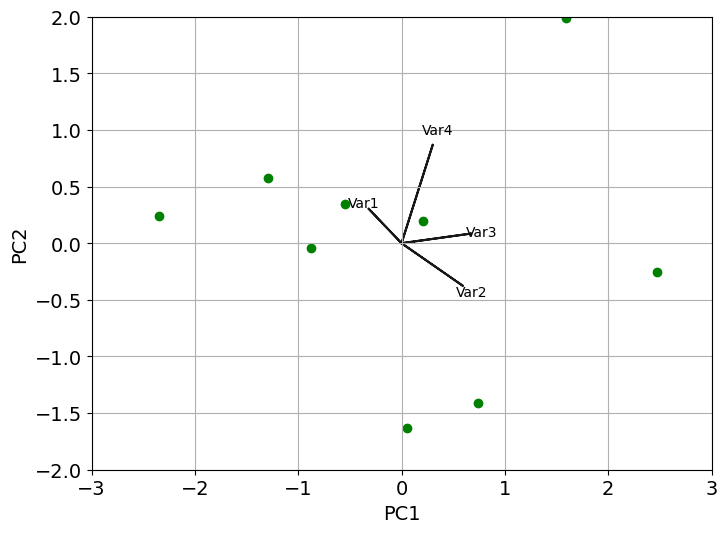

[-------------------------------- [Exercise 3] --------------------------------]


,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
0,7,48.0,1.0,1.0
1,7,30.0,0.0,0.0
2,7,88.0,3.0,1.0
3,6,12.0,1.0,0.0
4,7,92.0,1.0,0.0
5,3,110.0,3.0,2.0
6,7,82.0,1.0,1.0
7,6,190.0,3.0,0.0
8,6,133.0,1.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
Exercise 3,1.000000,-0.312772,-0.434783,0.043478
Exercise 3 Total Time,-0.312772,1.000000,0.521286,0.034752
Exercise 3 Times Needed Help,-0.434783,0.521286,1.000000,0.434783
Exercise 3 Number of Errors,0.043478,0.034752,0.434783,1.000000


,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
Exercise 3,1.000000,0.287726,0.185280,0.894615
Exercise 3 Total Time,0.287726,1.000000,0.076416,0.905969
Exercise 3 Times Needed Help,0.185280,0.076416,1.000000,0.185280
Exercise 3 Number of Errors,0.894615,0.905969,0.185280,1.000000


---- Question Exercise 3 ----
Population Standard Deviation:
1.227262335243029
Confidence Interval (95%):
(5.221640663984234, 7.222803780460211)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.652, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 3 Total Time ----
Population Standard Deviation:
51.31553322939638
Confidence Interval (95%):
(45.38489476092195, 129.0595496835225)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.967, p=0.872
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 3 Times Needed Help ----
Population Standard Deviation:
1.0657403385139377
Confidence Interval (95%):
(0.6866621674306844, 2.4244489436804266)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.773, p=0.010
Sample does not look Gaussian (reject H0)


---- Question Exercise 3 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.0028688326665212704, 1.1139799437776325)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.7

,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
0,0.525920,0.412495,0.590522,0.452261
1,0.266767,0.717144,0.204266,0.610586
2,0.803403,0.025646,0.388205,0.450758
3,0.082389,0.561155,0.677389,0.468467


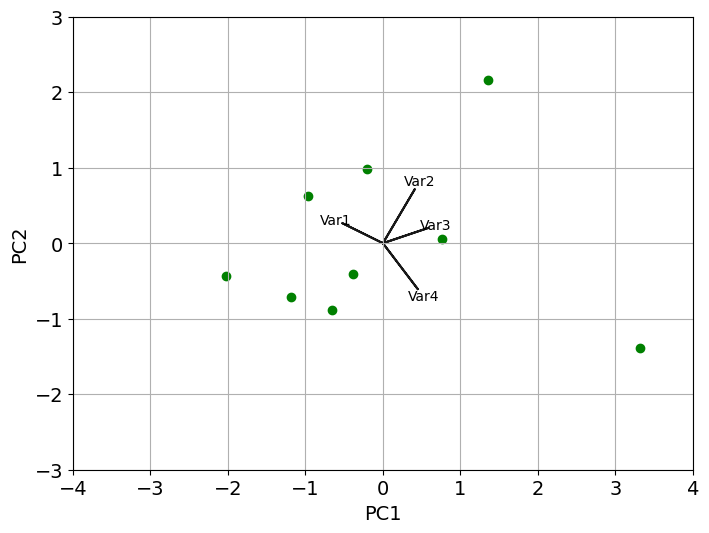

[-------------------------------- [Exercise 4] --------------------------------]


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
0,7,61.0,0.0,1.0
1,7,17.0,0.0,0.0
2,7,21.0,0.0,0.0
3,7,8.0,0.0,0.0
4,7,63.0,0.0,0.0
5,7,21.0,0.0,0.0
6,7,16.0,0.0,0.0
7,7,12.0,0.0,0.0
8,7,45.0,0.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
Exercise 4,1.0,NaN,NaN,NaN
Exercise 4 Total Time,NaN,1.000000,NaN,0.358569
Exercise 4 Times Needed Help,NaN,NaN,1.0,NaN
Exercise 4 Number of Errors,NaN,0.358569,NaN,1.000000


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
Exercise 4,1.000000,nan,nan,nan
Exercise 4 Total Time,nan,1.000000,nan,0.243305
Exercise 4 Times Needed Help,nan,nan,1.000000,nan
Exercise 4 Number of Errors,nan,0.243305,nan,1.000000


---- Question Exercise 4 ----
Population Standard Deviation:
0.0
Confidence Interval (95%):
(nan, nan)
Normality Tests:
Shapiro-Wilk Test
Statistics=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 4 Total Time ----
Population Standard Deviation:
20.016659728003237
Confidence Interval (95%):
(13.01383911745409, 45.652827549212574)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.820, p=0.035
Sample does not look Gaussian (reject H0)


---- Question Exercise 4 Times Needed Help ----
Population Standard Deviation:
0.0
Confidence Interval (95%):
(nan, nan)
Normality Tests:
Shapiro-Wilk Test
Statistics=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 4 Number of Errors ----
Population Standard Deviation:
0.31426968052735454
Confidence Interval (95%):
(-0.1451115705592635, 0.3673337927814857)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


Explained Variance Ratio: [0.77

C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
0,0.0,0.707107,0.0,0.707107
1,0.0,0.707107,0.0,0.707107
2,0.0,0.000000,1.0,0.000000
3,1.0,0.000000,0.0,0.000000


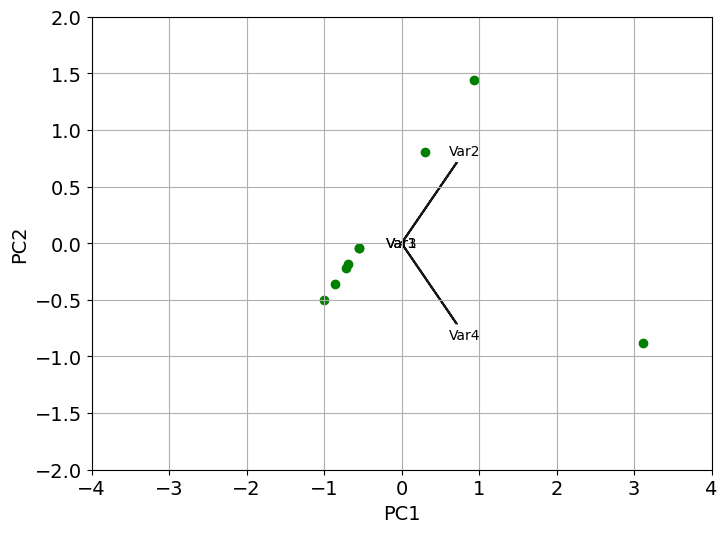

[-------------------------------- [Exercise 5] --------------------------------]


,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
0,7,17.0,0.0,0.0
1,7,22.0,0.0,0.0
2,7,36.0,0.0,0.0
3,6,35.0,1.0,1.0
4,7,38.0,0.0,0.0
5,6,42.0,1.0,0.0
6,7,42.0,0.0,0.0
7,7,47.0,1.0,0.0
8,7,41.0,0.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
Exercise 5,1.000000,-0.045175,-0.755929,-0.661438
Exercise 5 Total Time,-0.045175,1.000000,0.358569,-0.239046
Exercise 5 Times Needed Help,-0.755929,0.358569,1.000000,0.500000
Exercise 5 Number of Errors,-0.661438,-0.239046,0.500000,1.000000


,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
Exercise 5,1.000000,0.883133,0.032509,0.061369
Exercise 5 Total Time,0.883133,1.000000,0.243305,0.436661
Exercise 5 Times Needed Help,0.032509,0.243305,1.000000,0.157299
Exercise 5 Number of Errors,0.061369,0.436661,0.157299,1.000000


---- Question Exercise 5 ----
Population Standard Deviation:
0.415739709641549
Confidence Interval (95%):
(6.438827029800838, 7.116728525754717)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.536, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 5 Total Time ----
Population Standard Deviation:
9.2988782012923
Confidence Interval (95%):
(27.974221252916973, 43.136889858194145)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.869, p=0.121
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 5 Times Needed Help ----
Population Standard Deviation:
0.47140452079103173
Confidence Interval (95%):
(-0.051000689172228386, 0.7176673558388951)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.617, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 5 Number of Errors ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(-0.14511157055926338, 0.3673337927814856)
Normality Tests:
Shapiro-Wilk Test
Statistics=0

,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
0,0.591078,0.252511,0.585671,0.493817
1,0.171817,0.850584,0.192867,0.458026
2,0.366708,0.410090,0.416833,0.723604
3,0.697589,0.211119,0.667864,0.150848


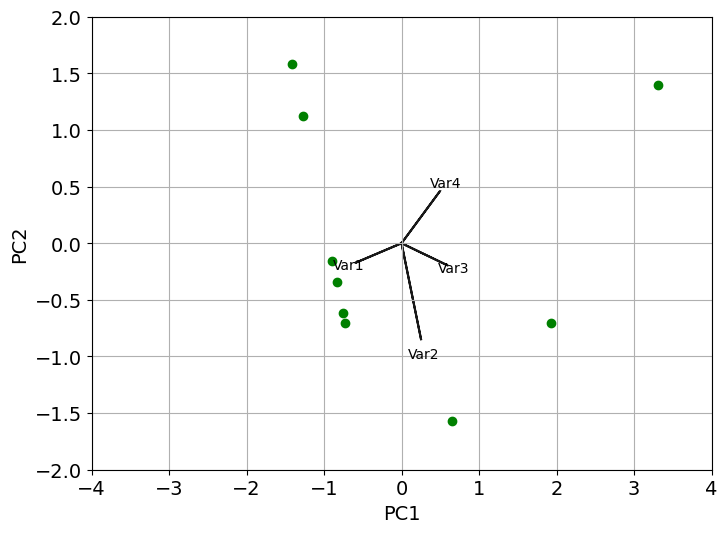

[-------------------------------- [Exercise 6] --------------------------------]


,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
0,7,15.0,0.0,0.0
1,7,15.0,0.0,0.0
2,7,12.0,0.0,0.0
3,7,11.0,0.0,0.0
4,7,11.0,0.0,0.0
5,7,16.0,0.0,0.0
6,6,33.0,1.0,1.0
7,7,16.0,0.0,0.0
8,7,66.0,0.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
Exercise 6,1.000000,-0.369274,-1.000000,-1.000000
Exercise 6 Total Time,-0.369274,1.000000,0.369274,0.369274
Exercise 6 Times Needed Help,-1.000000,0.369274,1.000000,1.000000
Exercise 6 Number of Errors,-1.000000,0.369274,1.000000,1.000000


,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
Exercise 6,1.000000,0.239317,0.004678,0.004678
Exercise 6 Total Time,0.239317,1.000000,0.239317,0.239317
Exercise 6 Times Needed Help,0.004678,0.239317,1.000000,0.004678
Exercise 6 Number of Errors,0.004678,0.239317,0.004678,1.000000


---- Question Exercise 6 ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(6.632666207218515, 7.145111570559264)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 6 Total Time ----
Population Standard Deviation:
16.89181261242657
Confidence Interval (95%):
(7.894846494365099, 35.43848683896824)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.636, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 6 Times Needed Help ----
Population Standard Deviation:
0.31426968052735443
Confidence Interval (95%):
(-0.14511157055926338, 0.3673337927814856)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 6 Number of Errors ----
Population Standard Deviation:
0.31426968052735443
Confidence Interval (95%):
(-0.14511157055926338, 0.3673337927814856)
Normality Tests:
Shapiro-Wilk Test
Statistics=

,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
0,0.566417,1.936860e-01,0.566417,0.566417
1,0.111825,9.810636e-01,0.111825,0.111825
2,0.816497,7.036113e-18,0.408248,0.408248
3,0.000000,6.331402e-17,0.707107,0.707107


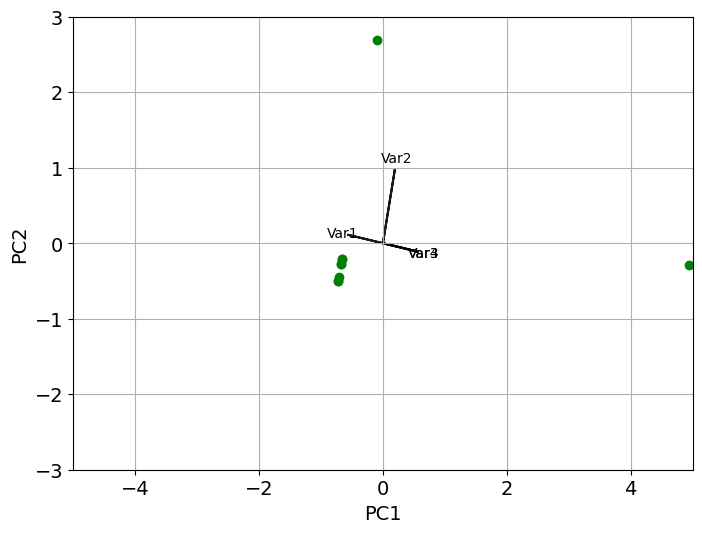

[-------------------------------- [Exercise 7] --------------------------------]


,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
0,6,88.0,2.0,1.0
1,7,65.0,0.0,0.0
2,7,119.0,1.0,0.0
3,5,13.0,4.0,2.0
4,6,95.0,0.0,0.0
5,4,102.0,2.0,2.0
6,7,86.0,0.0,0.0
7,6,73.0,0.0,0.0
8,6,105.0,0.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
Exercise 7,1.000000,0.032075,-0.461880,-0.731564
Exercise 7 Total Time,0.032075,1.000000,-0.033333,-0.149071
Exercise 7 Times Needed Help,-0.461880,-0.033333,1.000000,0.849706
Exercise 7 Number of Errors,-0.731564,-0.149071,0.849706,1.000000


,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
Exercise 7,1.000000,0.910794,0.137084,0.022042
Exercise 7 Total Time,0.910794,1.000000,0.907663,0.613354
Exercise 7 Times Needed Help,0.137084,0.907663,1.000000,0.008092
Exercise 7 Number of Errors,0.022042,0.613354,0.008092,1.000000


---- Question Exercise 7 ----
Population Standard Deviation:
0.9428090415820634
Confidence Interval (95%):
(5.231331954988876, 6.768668045011124)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.853, p=0.081
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 7 Total Time ----
Population Standard Deviation:
29.14120581827749
Confidence Interval (95%):
(59.13019257005175, 106.64758520772602)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.879, p=0.154
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 7 Times Needed Help ----
Population Standard Deviation:
1.3333333333333333
Confidence Interval (95%):
(-0.08706077421754355, 2.0870607742175435)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.763, p=0.008
Sample does not look Gaussian (reject H0)


---- Question Exercise 7 Number of Errors ----
Population Standard Deviation:
0.8314794192830981
Confidence Interval (95%):
(-0.12234594039832314, 1.2334570515094343)
Normality Tests:
Shapiro-Wilk Test
Statistics=0

,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
0,0.487970,0.358363,0.549643,0.575633
1,0.505920,0.835829,0.100861,0.187782
2,0.606320,0.415747,0.663408,0.139354
3,0.371895,0.010981,0.497603,0.783559


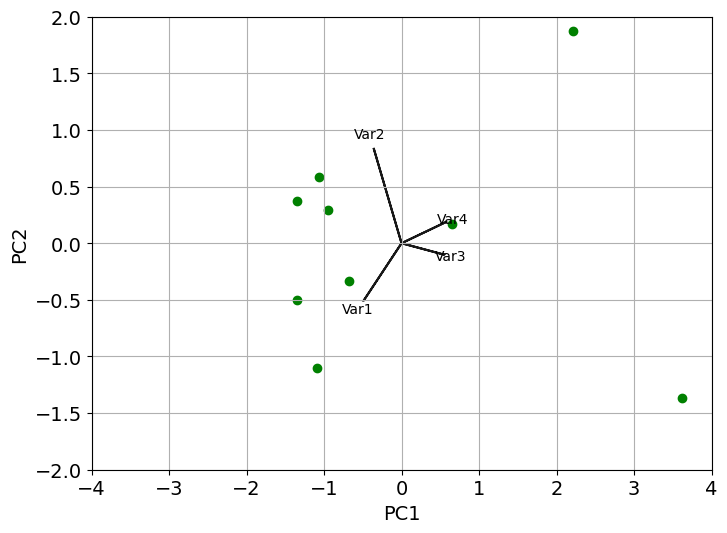

[-------------------------------- [Exercise 8] --------------------------------]


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
0,7,30.0,0.0,0.0
1,7,53.0,1.0,1.0
2,7,32.0,0.0,0.0
3,7,28.0,2.0,1.0
4,7,23.0,0.0,0.0
5,7,100.0,1.0,0.0
6,7,43.0,0.0,0.0
7,7,81.0,1.0,2.0
8,7,41.0,0.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
Exercise 8,1.0,NaN,NaN,NaN
Exercise 8 Total Time,NaN,1.000000,0.312772,0.223607
Exercise 8 Times Needed Help,NaN,0.312772,1.000000,0.699379
Exercise 8 Number of Errors,NaN,0.223607,0.699379,1.000000


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
Exercise 8,1.000000,nan,nan,nan
Exercise 8 Total Time,nan,1.000000,0.287726,0.448489
Exercise 8 Times Needed Help,nan,0.287726,1.000000,0.033640
Exercise 8 Number of Errors,nan,0.448489,0.033640,1.000000


---- Question Exercise 8 ----
Population Standard Deviation:
0.0
Confidence Interval (95%):
(nan, nan)
Normality Tests:
Shapiro-Wilk Test
Statistics=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 8 Total Time ----
Population Standard Deviation:
24.713668932369497
Confidence Interval (95%):
(27.739943826355656, 68.03783395142212)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.844, p=0.064
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 8 Times Needed Help ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.0028688326665212704, 1.1139799437776325)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.763, p=0.008
Sample does not look Gaussian (reject H0)


---- Question Exercise 8 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.11397994377763243, 1.0028688326665214)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.684, p=0.001
Sample does not look Gauss

C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\DevelopmentTools\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
0,0.0,0.463359,0.625752,0.627481
1,0.0,0.886130,0.333938,0.321339
2,0.0,0.008461,0.704926,0.709231
3,1.0,0.000000,0.000000,0.000000


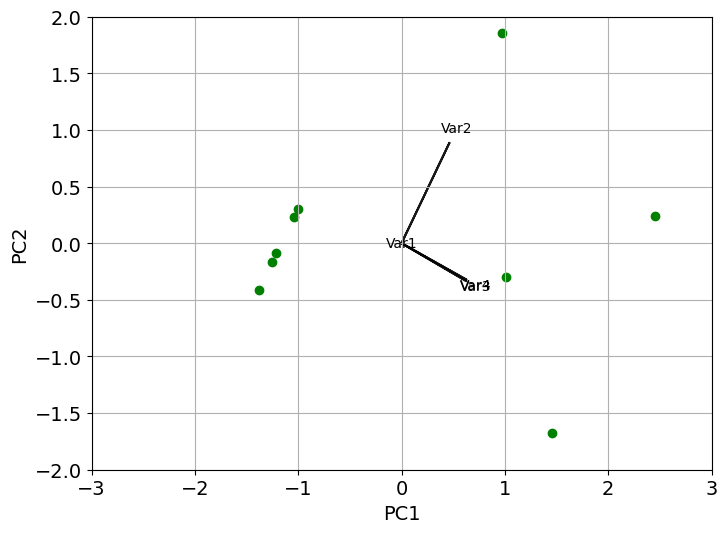

[-------------------------------- [Exercise 9] --------------------------------]


,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
0,6,106.0,2.0,1.0
1,7,137.0,2.0,2.0
2,6,84.0,1.0,0.0
3,4,124.0,3.0,1.0
4,5,97.0,1.0,0.0
5,1,204.0,4.0,2.0
6,6,178.0,4.0,0.0
7,6,116.0,2.0,1.0
8,6,156.0,3.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
Exercise 9,1.000000,-0.130744,-0.250640,-0.076923
Exercise 9 Total Time,-0.130744,1.000000,0.852013,0.326860
Exercise 9 Times Needed Help,-0.250640,0.852013,1.000000,0.214834
Exercise 9 Number of Errors,-0.076923,0.326860,0.214834,1.000000


,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
Exercise 9,1.000000,0.644901,0.404166,0.804338
Exercise 9 Total Time,0.644901,1.000000,0.002437,0.259544
Exercise 9 Times Needed Help,0.404166,0.002437,1.000000,0.484631
Exercise 9 Number of Errors,0.804338,0.259544,0.484631,1.000000


---- Question Exercise 9 ----
Population Standard Deviation:
1.6850834320114554
Confidence Interval (95%):
(3.8483811470545763, 6.596063297389868)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.750, p=0.005
Sample does not look Gaussian (reject H0)


---- Question Exercise 9 Total Time ----
Population Standard Deviation:
37.12474799349144
Confidence Interval (95%):
(103.28791258322855, 163.82319852788254)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.955, p=0.740
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 9 Times Needed Help ----
Population Standard Deviation:
1.0657403385139377
Confidence Interval (95%):
(1.5755510563195734, 3.313337832569316)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.899, p=0.248
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 9 Number of Errors ----
Population Standard Deviation:
0.7856742013183862
Confidence Interval (95%):
(0.13722107360184155, 1.418334481953714)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.80

,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
0,0.468997,0.584546,0.563492,0.347599
1,0.236704,0.289677,0.409726,0.831975
2,0.850867,0.236367,0.201631,0.423675
3,0.006201,0.720086,0.688437,0.086554


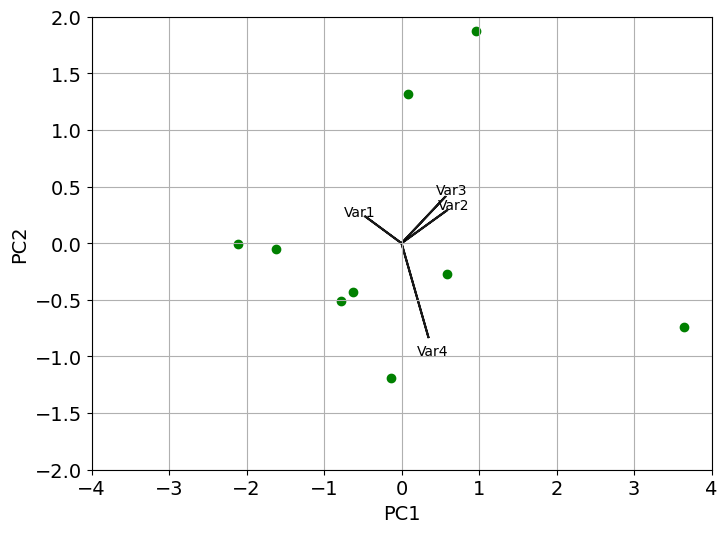

[-------------------------------- [Exercise 10] --------------------------------]


,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
0,7,39.0,0.0,0.0
1,7,31.0,0.0,0.0
2,7,46.0,1.0,1.0
3,6,64.0,1.0,1.0
4,7,38.0,0.0,0.0
5,7,83.0,2.0,1.0
6,7,31.0,1.0,1.0
7,7,58.0,0.0,0.0
8,7,78.0,1.0,1.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
Exercise 10,1.000000,-0.239046,-0.216506,-0.316228
Exercise 10 Total Time,-0.239046,1.000000,0.517549,0.415761
Exercise 10 Times Needed Help,-0.216506,0.517549,1.000000,0.912871
Exercise 10 Number of Errors,-0.316228,0.415761,0.912871,1.000000


,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
Exercise 10,1.000000,0.436661,0.524518,0.371093
Exercise 10 Total Time,0.436661,1.000000,0.081209,0.176098
Exercise 10 Times Needed Help,0.524518,0.081209,1.000000,0.007290
Exercise 10 Number of Errors,0.371093,0.176098,0.007290,1.000000


---- Question Exercise 10 ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(6.632666207218515, 7.145111570559264)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 10 Total Time ----
Population Standard Deviation:
18.55921454276674
Confidence Interval (95%):
(36.868754402702876, 67.13124559729712)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.900, p=0.250
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 10 Times Needed Help ----
Population Standard Deviation:
0.6666666666666666
Confidence Interval (95%):
(0.12313627955789486, 1.2101970537754383)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.805, p=0.024
Sample does not look Gaussian (reject H0)


---- Question Exercise 10 Number of Errors ----
Population Standard Deviation:
0.4969039949999533
Confidence Interval (95%):
(0.1504319244182259, 0.9606791866928852)
Normality Tests:
Shapiro-Wilk Test
Statistics=

,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
0,0.267127,0.494756,0.592372,0.577023
1,0.955125,0.122582,0.260505,0.069627
2,0.012359,0.836871,0.213837,0.503753
3,0.127386,0.199592,0.731783,0.639085


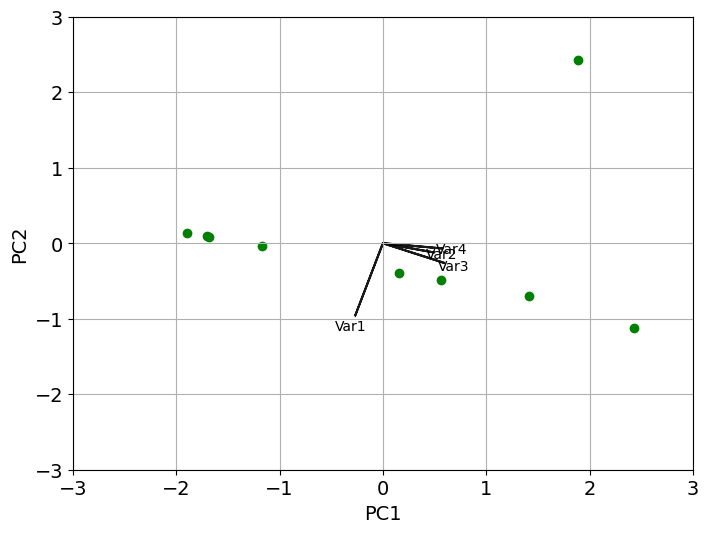

[-------------------------------- [Exercise 11] --------------------------------]


,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,7,11.0,0.0,0.0
1,7,20.0,0.0,0.0
2,7,30.0,1.0,1.0
3,7,25.0,0.0,0.0
4,7,24.0,0.0,0.0
5,6,32.0,1.0,1.0
6,7,25.0,0.0,0.0
7,7,32.0,1.0,0.0
8,7,34.0,0.0,0.0


Correlations:
Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
Exercise 11,1.000000,-0.303170,-0.500000,-0.661438
Exercise 11 Total Time,-0.303170,1.000000,0.485071,0.320844
Exercise 11 Times Needed Help,-0.500000,0.485071,1.000000,0.755929
Exercise 11 Number of Errors,-0.661438,0.320844,0.755929,1.000000


,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
Exercise 11,1.000000,0.328858,0.157299,0.061369
Exercise 11 Total Time,0.328858,1.000000,0.118225,0.301444
Exercise 11 Times Needed Help,0.157299,0.118225,1.000000,0.032509
Exercise 11 Number of Errors,0.061369,0.301444,0.032509,1.000000


---- Question Exercise 11 ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(6.632666207218515, 7.145111570559264)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 11 Total Time ----
Population Standard Deviation:
6.822258414670556
Confidence Interval (95%):
(20.326731753265946, 31.451046024511832)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.907, p=0.295
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 11 Times Needed Help ----
Population Standard Deviation:
0.47140452079103173
Confidence Interval (95%):
(-0.051000689172228386, 0.7176673558388951)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.617, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 11 Number of Errors ----
Population Standard Deviation:
0.41573970964154905
Confidence Interval (95%):
(-0.1167285257547171, 0.5611729701991615)
Normality Tests:
Shapiro-Wilk Test
Stati

,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,0.473513,0.417686,0.546642,0.550006
1,0.534111,0.783763,0.146534,0.281015
2,0.649331,0.417655,0.532495,0.346962
3,0.262449,0.191883,0.629412,0.705792


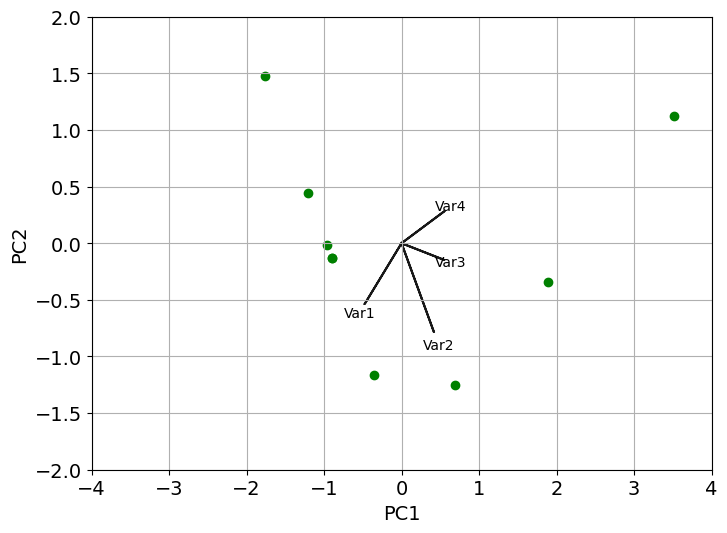

In [78]:
for i in range(1,12):
    print('[-------------------------------- [Exercise '+str(i)+'] --------------------------------]')
    data_exercise = data_exercises_seq.filter(regex='Exercise ('+str(i)+'$|'+str(i)+' [A-z]+)').drop(columns='Exercise '+str(i)+' Time First Needed Help').dropna()
    display(data_exercise)
    
    print('Correlations:')
    calculate_correlation(data_exercise)
    
    for column in data_exercise:
        print('---- Question', column,'----')
        print('Population Standard Deviation:')
        print(data_exercise[column].std(ddof=0))
        print('Confidence Interval (95%):')
        print(confidence_interval_t(data_exercise[column]))
        print('Normality Tests:')
        normality_tests(data_exercise[column])
        print('\n')
    
    data_exercise_scaled = StandardScaler().fit_transform(data_exercise)
    pca = PCA()
    principalComponents = pca.fit_transform(data_exercise_scaled)
    principalDf = pd.DataFrame(data=principalComponents[:,0:2], columns=['principal component 1', 'principal component 2'])
    print('Explained Variance Ratio:',pca.explained_variance_ratio_)
    print('Components:')
    display(pd.DataFrame(abs(pca.components_), columns=data_exercise.columns))
    
    biplot(principalComponents[:,0:2], np.transpose(pca.components_[0:2, :]), None)
    plt.show()

## General Analysis

In [79]:
data_full = data['Full'].drop(columns=[
    'Participant',
    'Timestamp',
    'Gender',
    'Education',
    'Education Area',
    'Devices Owned',
    'Experience with Programming Languages',
    'Additional Feedback',
    'Contact'
]).dropna(axis='columns')

data_full['Number of Devices Owned'] = num_devices_owned
data_full['Number of Programming Languages'] = num_programming_languages

data_full = data_full[[
    'Age',
    'Number of Devices Owned',
    'Usage of Multiple Devices',
    'Years of Programming Experience',
    'Programming Experience (Self Assessment)',
    'JavaScript Experience (Self Assessment)',
    'Number of Programming Languages',
    'DS1',
    'DS2',
    'DS3',
    'DS4',
    'DS5',
    'DS6',
    'DS7',
    'DS8', 
    'ULI1', 
    'ULI2', 
    'SDS1', 
    'SDS2',
    'SDS3',
    'SDS4',
    'SDS5',
    'SDS6',
    'NPS'
]]

data_full

,Age,Number of Devices Owned,Usage of Multiple Devices,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Number of Programming Languages,DS1,DS2,DS3,...,DS8,ULI1,ULI2,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6,NPS
0,52,3,7,30,6,6,9,7,7,7,...,7,7,7,7,5,7,7,7,7,9
1,23,2,5,5,6,6,7,7,6,6,...,5,4,6,5,6,6,7,7,7,8
2,24,6,6,6,4,4,4,5,7,6,...,7,6,6,7,2,6,3,6,2,9
3,22,3,3,5,6,5,5,7,6,6,...,7,7,7,7,6,7,6,7,7,9
4,22,3,6,7,5,5,9,6,6,6,...,6,7,6,7,6,7,6,6,6,8
5,24,5,5,5,4,4,4,7,6,6,...,6,6,7,7,7,7,7,7,5,7
6,35,7,7,20,7,7,6,7,6,7,...,7,6,7,7,7,7,7,7,7,10
7,25,5,5,6,5,5,6,7,7,7,...,6,6,7,7,6,6,6,6,6,10
8,29,5,7,4,3,3,6,7,6,6,...,7,7,5,7,5,6,5,5,5,10
9,25,4,6,6,5,5,7,6,7,6,...,6,7,6,7,4,7,4,6,6,9


### General Correlation

In [80]:
general_correlations = calculate_correlation(data_full);

Kendall Correlation


C:\Users\Pedro\AppData\Local\Temp/ipykernel_10132/1352167546.py:151: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,Age,Number of Devices Owned,Usage of Multiple Devices,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Number of Programming Languages,DS1,DS2,DS3,...,DS8,ULI1,ULI2,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6,NPS
Age,1.000000,0.111390,0.505044,0.581562,0.315637,0.221579,0.238106,0.492891,0.069905,0.190869,...,0.141288,0.078782,-0.010443,0.306032,-0.040505,0.130287,0.000000,0.066549,0.010182,0.079932
Number of Devices Owned,0.111390,1.000000,0.128542,-0.081203,-0.174866,-0.086488,-0.071563,-0.144863,0.343911,0.360089,...,0.171439,0.163490,0.302665,0.367139,0.260870,0.158090,0.048390,0.082423,-0.010929,0.327107
Usage of Multiple Devices,0.505044,0.128542,1.000000,0.459269,0.354022,0.244580,0.404748,0.220214,0.077161,-0.076612,...,0.318690,0.121744,-0.144093,-0.019871,-0.050299,-0.068780,0.005529,0.062156,0.050575,-0.005514
Years of Programming Experience,0.581562,-0.081203,0.459269,1.000000,0.597048,0.408872,0.343684,0.294082,0.105105,0.040583,...,0.080047,-0.126349,-0.109915,0.090222,-0.076127,0.039746,-0.020084,-0.051312,0.020412,-0.190288
Programming Experience (Self Assessment),0.315637,-0.174866,0.354022,0.597048,1.000000,0.706563,0.483126,0.310313,-0.088021,-0.087394,...,0.000000,-0.209734,-0.016907,-0.116574,0.081968,0.055023,0.129747,0.127074,0.280220,-0.221064
JavaScript Experience (Self Assessment),0.221579,-0.086488,0.244580,0.408872,0.706563,1.000000,0.564332,0.219256,0.031096,0.055575,...,-0.170515,-0.106537,0.284309,0.000000,0.237841,0.211667,0.342251,0.333378,0.429373,-0.026668
Number of Programming Languages,0.238106,-0.071563,0.404748,0.343684,0.483126,0.564332,1.000000,0.154022,0.182315,-0.035036,...,-0.117833,-0.058326,-0.026358,0.012116,0.097121,0.034313,0.161823,0.087858,0.272401,-0.065566
DS1,0.492891,-0.144863,0.220214,0.294082,0.310313,0.219256,0.154022,1.000000,-0.101452,0.309385,...,0.129907,-0.013067,0.155893,0.209008,0.359009,0.169119,0.380094,0.305664,0.265983,0.024858
DS2,0.069905,0.343911,0.077161,0.105105,-0.088021,0.031096,0.182315,-0.101452,1.000000,0.428582,...,-0.007586,0.019459,0.257946,0.185267,0.068782,0.041974,0.160837,0.177017,0.182329,0.302314
DS3,0.190869,0.360089,-0.076612,0.040583,-0.087394,0.055575,-0.035036,0.309385,0.428582,1.000000,...,0.210908,0.141682,0.486610,0.367896,0.428381,0.430649,0.405374,0.332683,0.430729,0.422677


,Age,Number of Devices Owned,Usage of Multiple Devices,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Number of Programming Languages,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8,ULI1,ULI2,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6,NPS
Age,1.000000,0.514041,0.003551,0.000397,0.066559,0.194401,0.148741,0.006202,0.701699,0.291504,0.314178,0.275659,0.084196,0.649790,0.445085,0.652371,0.952301,0.098060,0.813333,0.470987,1.000000,0.699078,0.952698,0.638951
Number of Devices Owned,0.514041,1.000000,0.476892,0.635151,0.329856,0.627228,0.677181,0.440899,0.071056,0.056585,0.826164,0.318831,0.687616,0.973390,0.374826,0.370255,0.096587,0.057319,0.144850,0.402022,0.785426,0.646246,0.951324,0.065639
Usage of Multiple Devices,0.003551,0.476892,1.000000,0.008183,0.051963,0.176056,0.020333,0.248532,0.689973,0.689512,0.324513,0.681635,0.708904,0.361641,0.104218,0.511015,0.435815,0.919295,0.781821,0.719518,0.975551,0.733113,0.780788,0.975609
Years of Programming Experience,0.000397,0.635151,0.008183,1.000000,0.000537,0.016922,0.037619,0.103379,0.565704,0.822995,0.410336,0.544857,0.171282,0.314821,0.666104,0.471163,0.530043,0.626658,0.658021,0.826385,0.906426,0.766242,0.905581,0.265261
Programming Experience (Self Assessment),0.066559,0.329856,0.051963,0.000537,1.000000,0.000083,0.005295,0.101511,0.646761,0.646250,0.178417,0.514069,1.000000,0.815849,1.000000,0.254184,0.926637,0.549397,0.649489,0.772337,0.468940,0.482677,0.120492,0.217115
JavaScript Experience (Self Assessment),0.194401,0.627228,0.176056,0.016922,0.000083,1.000000,0.001031,0.243587,0.870389,0.768647,0.006047,0.710125,0.548712,0.426042,0.377563,0.559437,0.118676,1.000000,0.183902,0.262011,0.054232,0.063472,0.016509,0.880740
Number of Programming Languages,0.148741,0.677181,0.020333,0.037619,0.005295,0.001031,1.000000,0.395789,0.321277,0.847550,0.118925,0.693120,0.896059,0.672558,0.527186,0.740524,0.880833,0.948152,0.573970,0.850481,0.345702,0.612313,0.115045,0.702341
DS1,0.006202,0.440899,0.248532,0.103379,0.101511,0.243587,0.395789,1.000000,0.614372,0.121122,0.428544,0.218528,0.071746,0.486958,0.524671,0.945944,0.417748,0.305975,0.057397,0.396244,0.042810,0.106969,0.159429,0.894583
DS2,0.701699,0.071056,0.689973,0.565704,0.646761,0.870389,0.321277,0.614372,1.000000,0.034167,0.251723,0.108101,0.517116,0.151795,0.970769,0.920656,0.185920,0.370776,0.719452,0.835468,0.397748,0.357051,0.341326,0.111850
DS3,0.291504,0.056585,0.689512,0.822995,0.646250,0.768647,0.847550,0.121122,0.034167,1.000000,0.199464,0.007313,0.027881,0.008795,0.304056,0.464405,0.011829,0.072955,0.024034,0.031575,0.031560,0.080806,0.023358,0.024941


In [81]:
with pd.ExcelWriter('out/yanux-skeletron-correlations.xlsx') as writer:  
    data_full.to_excel(writer, sheet_name='Full Data')
    for correlations in general_correlations:
        general_correlations[correlations].to_excel(writer, sheet_name=correlations)